In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import pickle
from tqdm import trange
import blimpy as bl
import os
import time
from scipy import stats
from turbo_seti import find_event
import gc
%matplotlib inline

bshuf filter already loaded, skip it.


In [2]:
print("Blimpy version:", bl.__version__)

Blimpy version: 2.0.10


First we will read in the data that I processed on GCP

For simplicity, I will start with the L-band files from turboSETI, and then make a function so that I can repeat the process on other bands as well as the energy detection data

In [3]:
dir_path = "/home/danielb/fall_2021/spectral_occupancy/"
ts = dir_path + "turbo-seti/"
ed = dir_path + "energy-detection/"
fine = ed + "fine_channel_fraction/"

In [4]:
ts_pickles = glob.glob(ts+"*pkl")
ed_pickles = glob.glob(ed+"*pkl")

In [5]:
def read_pickle(pickle_path):
    with open(pickle_path, "rb") as f:
        contents = pickle.load(f)
    return contents

In [6]:
l_band = read_pickle(ts_pickles[2])

In [7]:
def sample_spectrum(spectral_occupancy):
    return np.random.random(size=len(spectral_occupancy))

def simulate_cadence(spectral_occupancy):
    on_target = np.empty(shape=(3, len(spectral_occupancy)), dtype=bool)
    off_target= np.empty(shape=(3, len(spectral_occupancy)), dtype=bool)
    for i in range(3):
        on_target[i,:] = sample_spectrum(spectral_occupancy) <= spectral_occupancy
    
    for i in range(3):
        off_target[i, :] = sample_spectrum(spectral_occupancy) <= spectral_occupancy
    
    return on_target, off_target

def signal_search(spectral_occupancy):
    """
    currently set to filter level 3:
    events that are present in *ALL* ons
    and found in *NO* offs 
    """
    on, off = simulate_cadence(spectral_occupancy)
    # signals should be present in all ons
    all_on = np.sum(on, axis=0) == 3
    
    # signals should be absent in all offs
    no_off = np.sum(off, axis=0) == 0
    
    #check that hits are present in "ons" and absent in "offs"
    hit_detection = (all_on & no_off)
    
    return hit_detection

def search_n_times(spectral_occupancy, N_iterations=10000):
    search_results = np.empty(shape=(N_iterations, len(spectral_occupancy)))
    
    for i in trange(N_iterations):
        search_results[i,:] = signal_search(spectral_occupancy)
    
    return search_results

In [8]:
results = search_n_times(l_band["bin_heights"])
event_counts = np.sum(results, axis=0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 10776.00it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3410.17it/s]


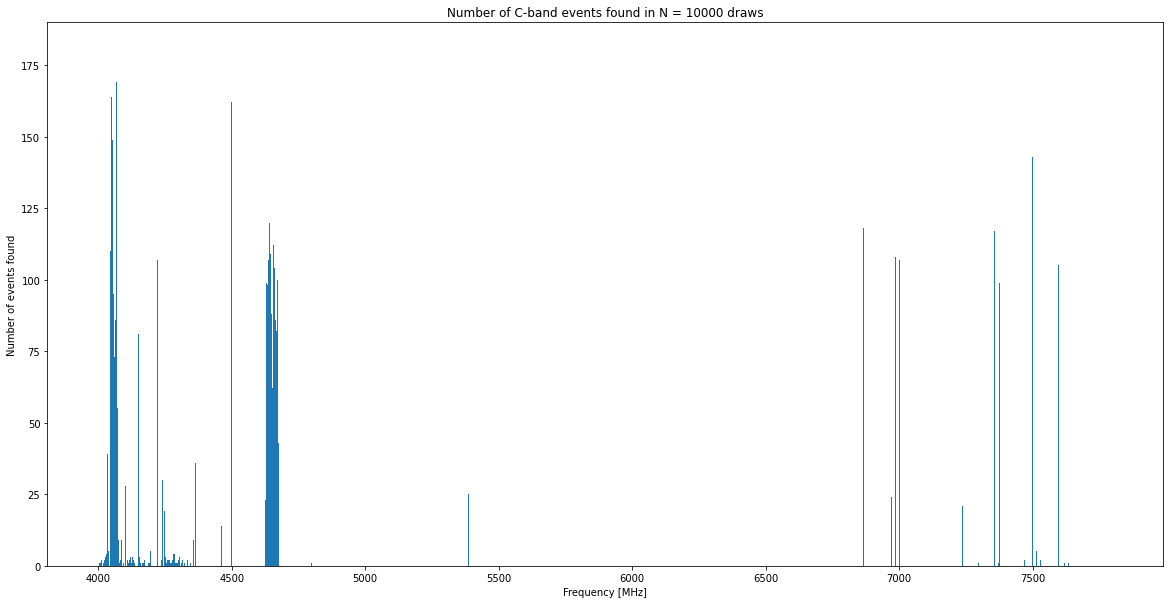

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 9920.76it/s]


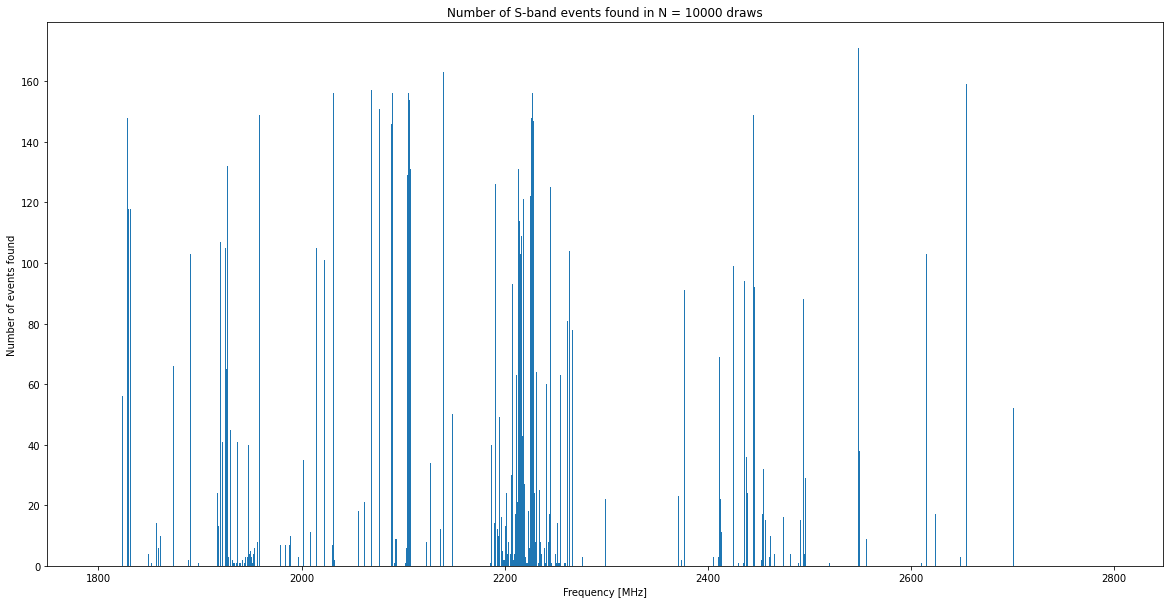

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 11990.44it/s]


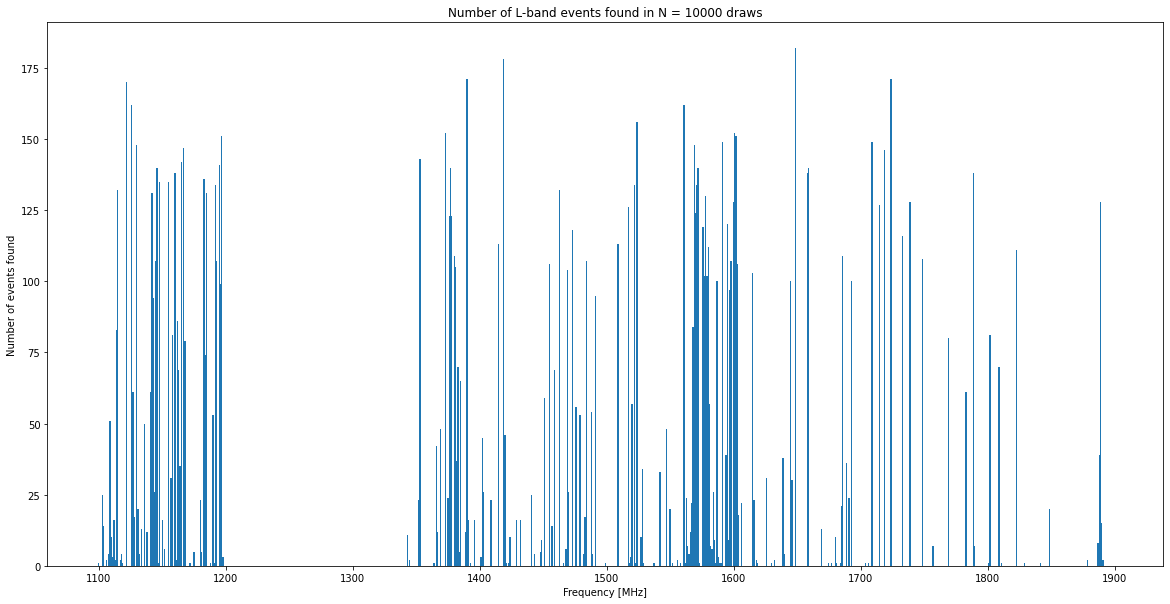

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3881.87it/s]


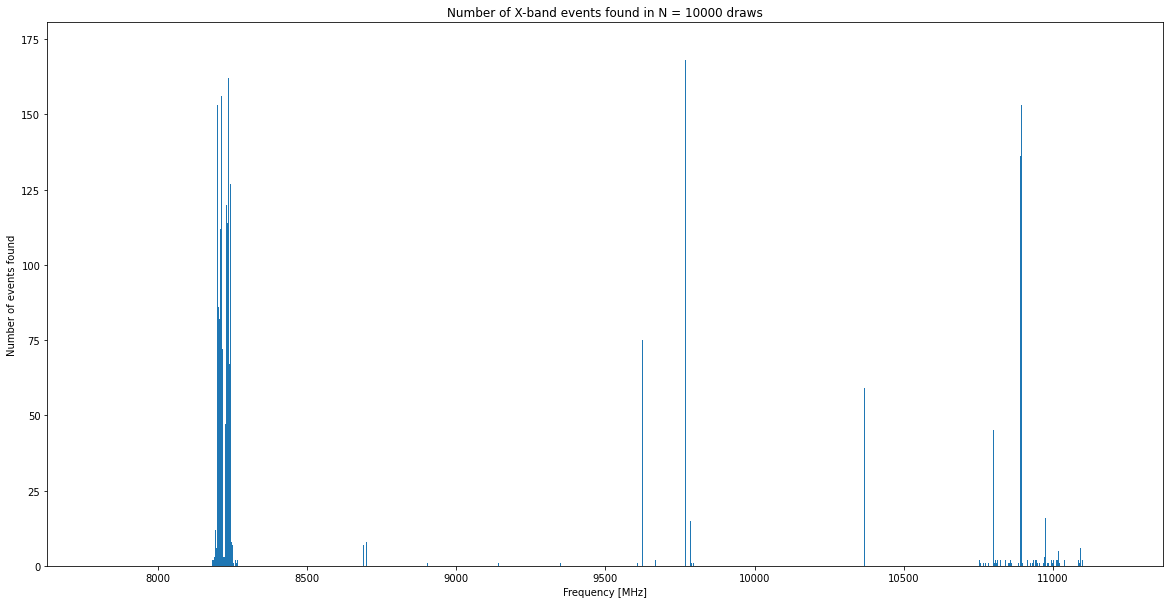

In [9]:
for i in range(4):
    data = ts_pickles[i]
    data = read_pickle(data)

    results = search_n_times(data["bin_heights"])
    event_counts = np.sum(results, axis=0)

    plt.figure(figsize=(20,10))
    plt.bar(data["bin_edges"][:-1], event_counts, width=1)
    plt.title("Number of %s-band events found in N = %i draws"%(data["band"], len(results)))
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Number of events found")
    plt.show()

# repeating the process with energy detection data

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3496.54it/s]


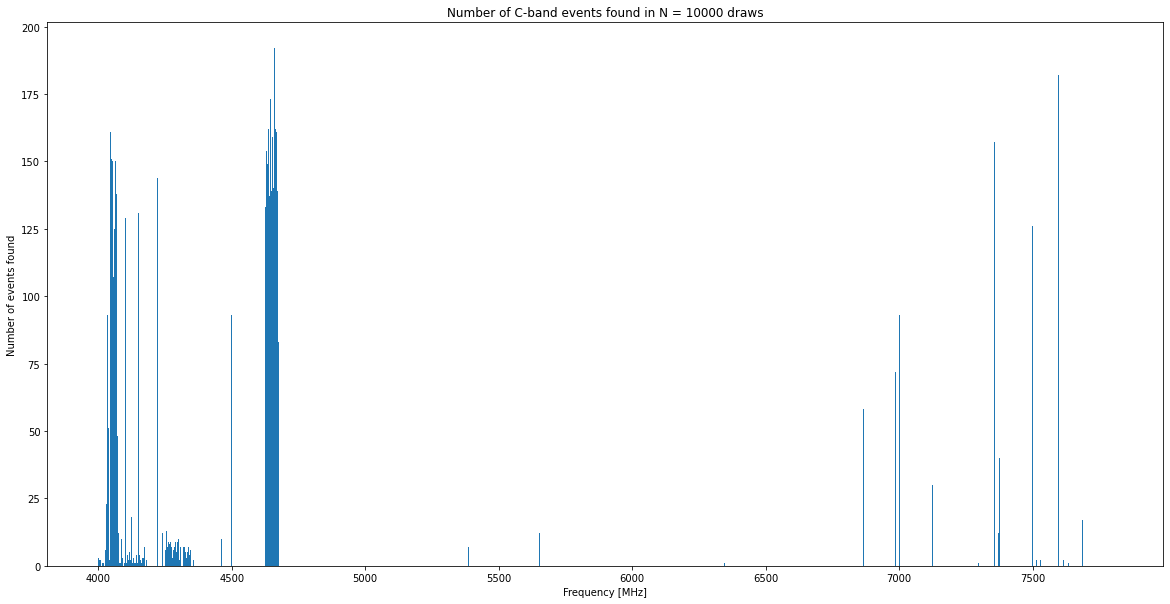

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 12135.10it/s]


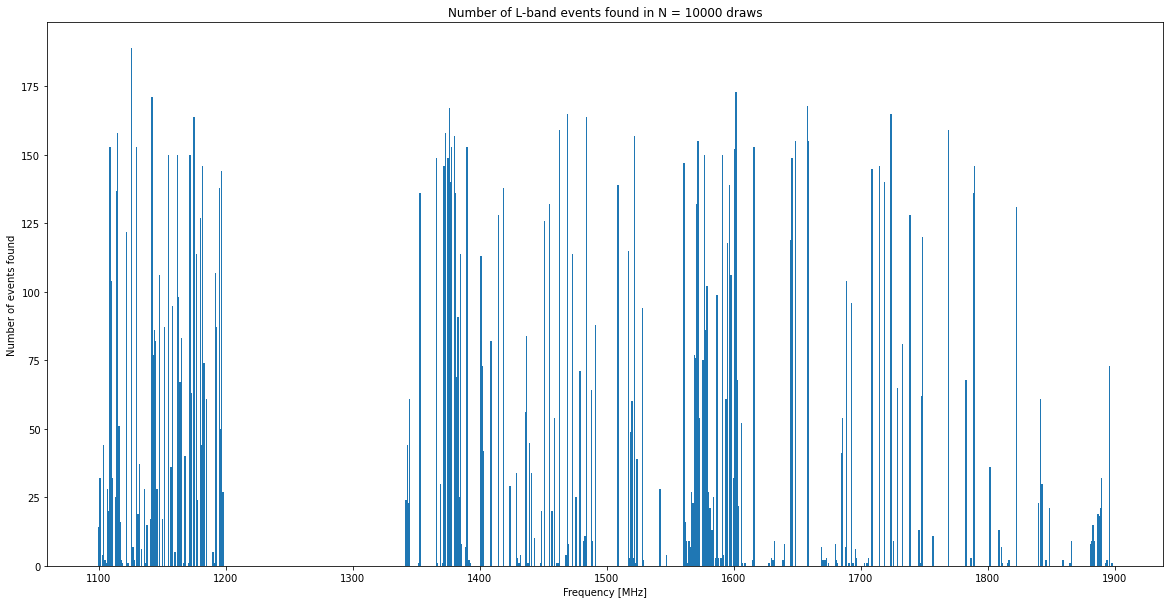

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 9780.73it/s]


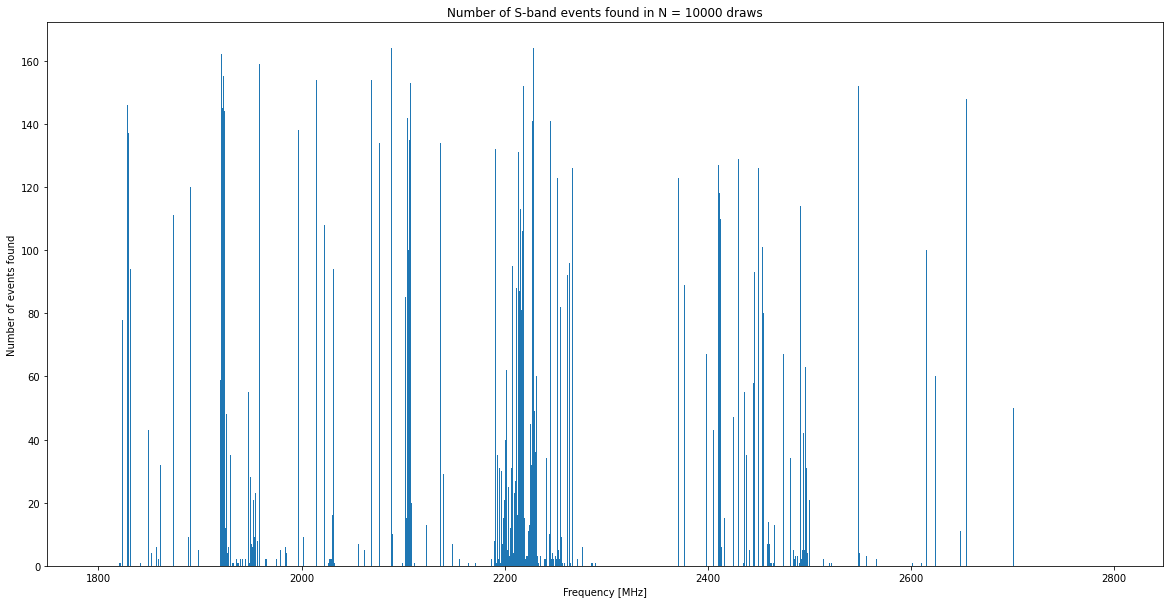

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3874.35it/s]


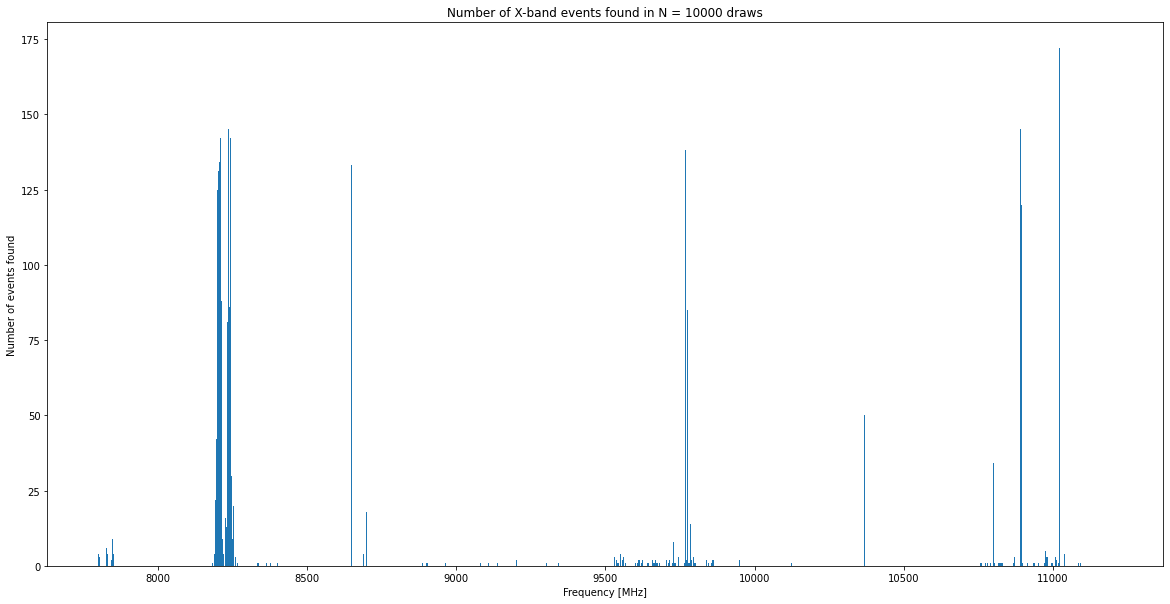

In [10]:
for i in range(4):
    data = ed_pickles[i]
    data = read_pickle(data)

    results = search_n_times(data["bin_heights"])
    event_counts = np.sum(results, axis=0)

    plt.figure(figsize=(20,10))
    plt.bar(data["bin_edges"][:-1], event_counts, width=1)
    plt.title("Number of %s-band events found in N = %i draws"%(data["band"], len(results)))
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Number of events found")
    plt.show()

# Ratio of bin height vs frequency comparing energy detection and turboSETI

In [11]:
ed_data = read_pickle(ed_pickles[1])
ts_data = read_pickle(ts_pickles[2])

/tmp/ipykernel_957925/2297618612.py:1: RuntimeWarning: divide by zero encountered in true_divide
  ed_over_ts = ed_data["bin_heights"]/ts_data["bin_heights"]
/tmp/ipykernel_957925/2297618612.py:1: RuntimeWarning: invalid value encountered in true_divide
  ed_over_ts = ed_data["bin_heights"]/ts_data["bin_heights"]
/tmp/ipykernel_957925/2297618612.py:2: RuntimeWarning: divide by zero encountered in true_divide
  ts_over_ed = ts_data["bin_heights"]/ed_data["bin_heights"]
/tmp/ipykernel_957925/2297618612.py:2: RuntimeWarning: invalid value encountered in true_divide
  ts_over_ed = ts_data["bin_heights"]/ed_data["bin_heights"]


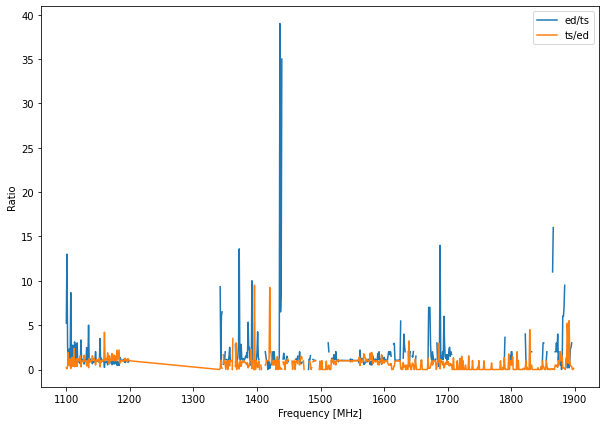

In [12]:
ed_over_ts = ed_data["bin_heights"]/ts_data["bin_heights"]
ts_over_ed = ts_data["bin_heights"]/ed_data["bin_heights"]

plt.figure(figsize=(10,7))
plt.plot(ts_data["bin_edges"][:-1], ed_over_ts, label="ed/ts")
plt.plot(ts_data["bin_edges"][:-1], ts_over_ed, label="ts/ed")
plt.legend()
plt.xlabel("Frequency [MHz]")
plt.ylabel("Ratio")
# plt.yscale("log")
plt.show()

# Fraction of fine channels that detect a signal 

In [13]:
fine_pickles = glob.glob(fine+"*pkl")
fine_pickles.sort()

In [14]:
fine_pickles

['/home/danielb/fall_2021/spectral_occupancy/energy-detection/fine_channel_fraction/energy_detection_C_band_fine_channel_fraction.pkl',
 '/home/danielb/fall_2021/spectral_occupancy/energy-detection/fine_channel_fraction/energy_detection_L_band_fine_channel_fraction.pkl',
 '/home/danielb/fall_2021/spectral_occupancy/energy-detection/fine_channel_fraction/energy_detection_S_band_fine_channel_fraction.pkl',
 '/home/danielb/fall_2021/spectral_occupancy/energy-detection/fine_channel_fraction/energy_detection_X_band_fine_channel_fraction.pkl']

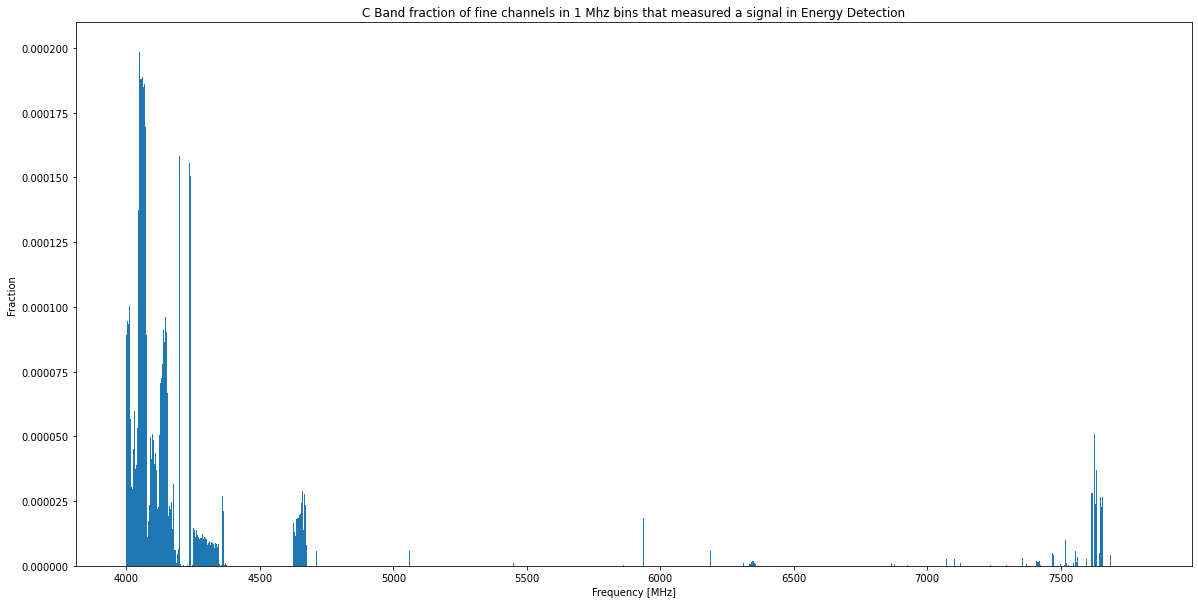

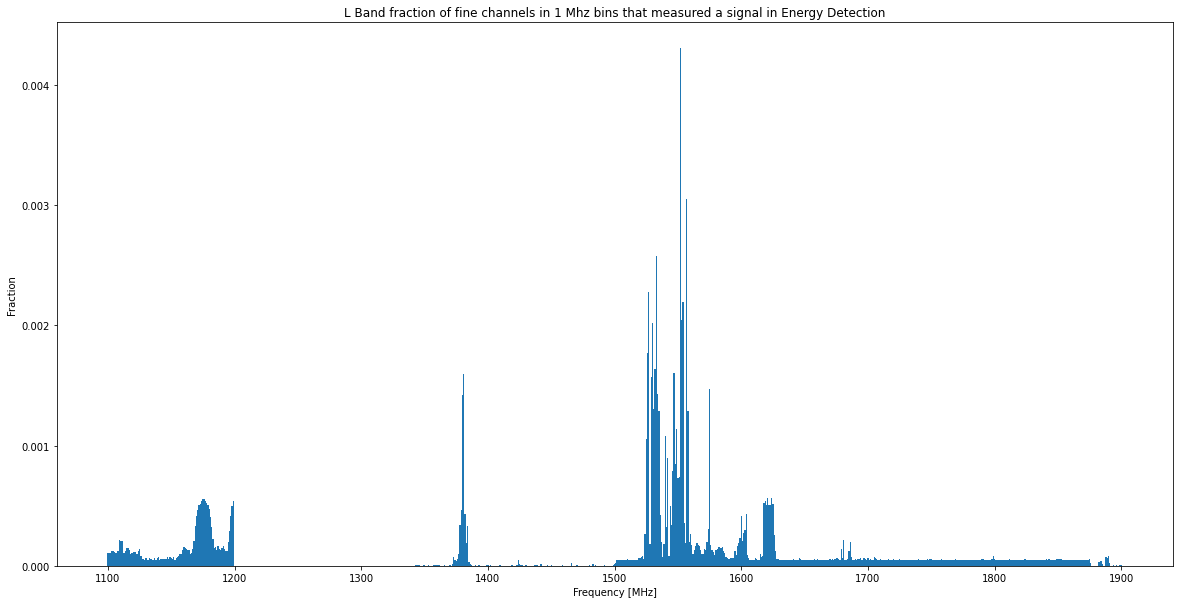

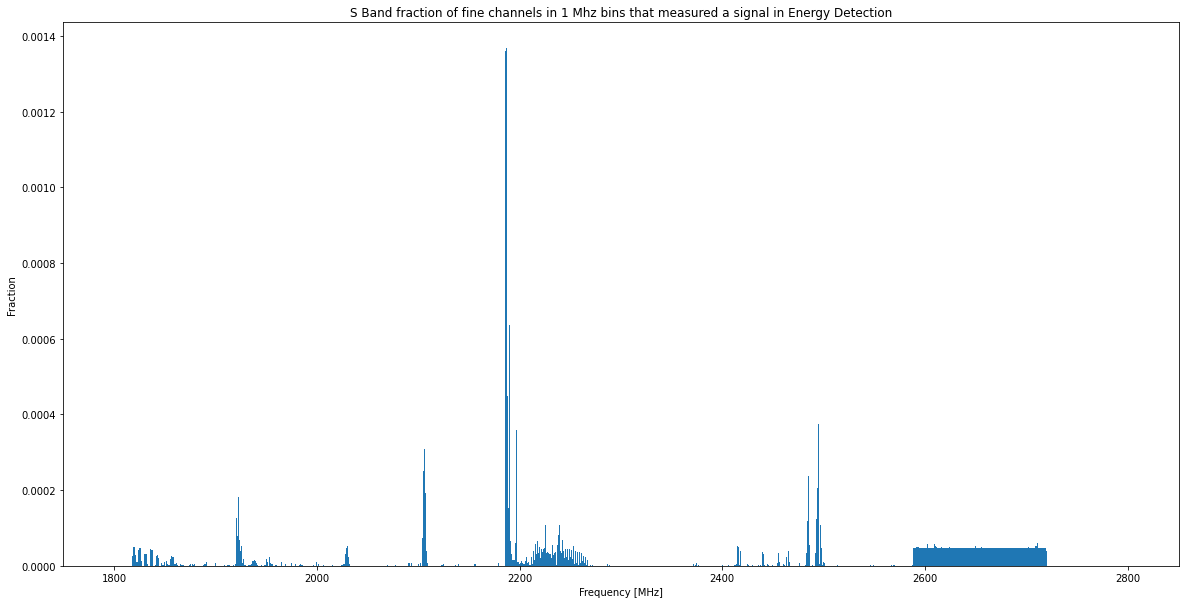

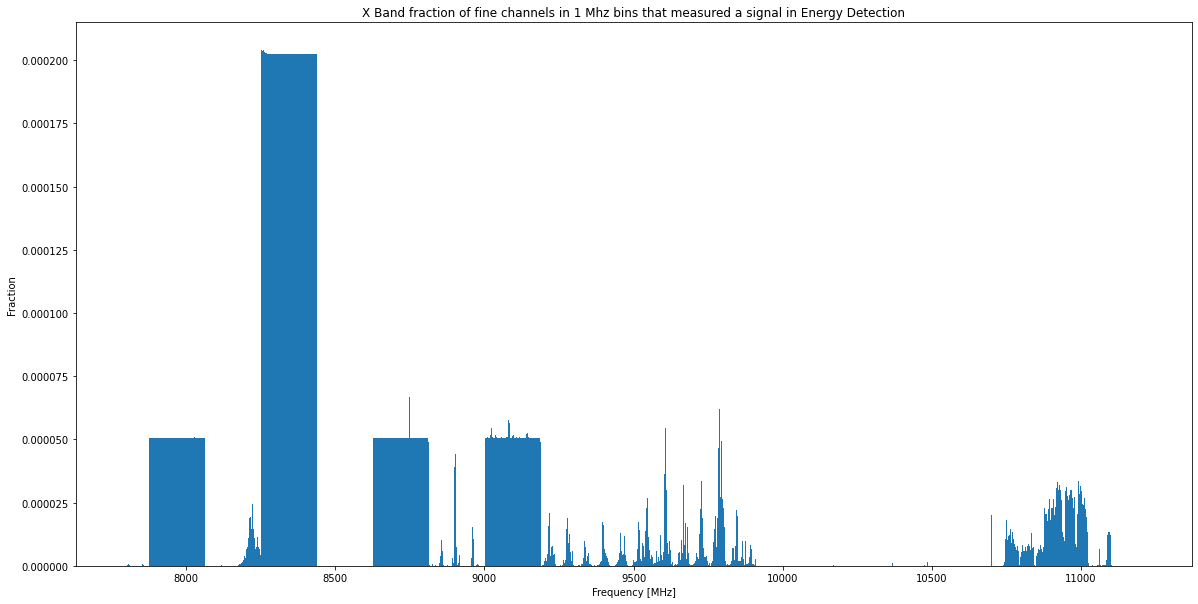

In [15]:
for i in range(4):
    fraction_data = read_pickle(fine_pickles[i])
    fractions = fraction_data["fine channel fraction"]
    frequencies = fraction_data["frequency bin"]
    band = fraction_data["band"]
    savepath = "/home/danielb/fall_2021/fine_channel_plots/%s_band_energy_detection_fine_channel_fraction.pdf"%band
    
    plt.figure(figsize=(20,10))
    plt.bar(frequencies, fractions, width=1)
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Fraction")
    plt.title("%s Band fraction of fine channels in %s Mhz bins that measured a signal in Energy Detection"%(fraction_data["band"], fraction_data["bin_width"]))
    plt.savefig(savepath, bbox_inches='tight', transparent=False)

### Interesting details

~X band has intervals with a much higher fraction than the surrounding~ this has been identified as dropped compute nodes in some files and has been corrected

L band has an interval of constant fraction in frequencies between ~1650-1900 MHz



# Comparing turboSETI and Energy Detection histograms

- There are `.h5` files that are missing `.dat` files and need to have `turboSETI` run on them. This will result in the number of files being equal across energy detection and turbo seti and will allow for an equal comparison

#### turboSETI in process

- L band completed
- S band completed
- C band completed
- X band in progress

In [16]:
csv_dir = "/home/danielb/fall_2021/histograms/energy_detection_csvs/"
csv_files = glob.glob(csv_dir+"*band_energy_detection_hist_threshold_4096.csv")
csv_files.sort()

hist = pd.read_csv(csv_files[0])

In [17]:
dat_dir = "/home/danielb/fall_2021/histograms/turboSETI/"
dat_csvs= glob.glob(dat_dir+"*band_turboSETI*.csv")
dat_csvs.sort()

dat_hist = pd.read_csv(dat_csvs[0])

In [18]:
titles = ["L band", "S band", "C band", "X band"]
titles.sort()

In [19]:
dat_csvs

['/home/danielb/fall_2021/histograms/turboSETI/C_band_turboSETI_hist.csv',
 '/home/danielb/fall_2021/histograms/turboSETI/L_band_turboSETI_hist.csv',
 '/home/danielb/fall_2021/histograms/turboSETI/S_band_turboSETI_hist.csv',
 '/home/danielb/fall_2021/histograms/turboSETI/X_band_turboSETI_hist.csv']

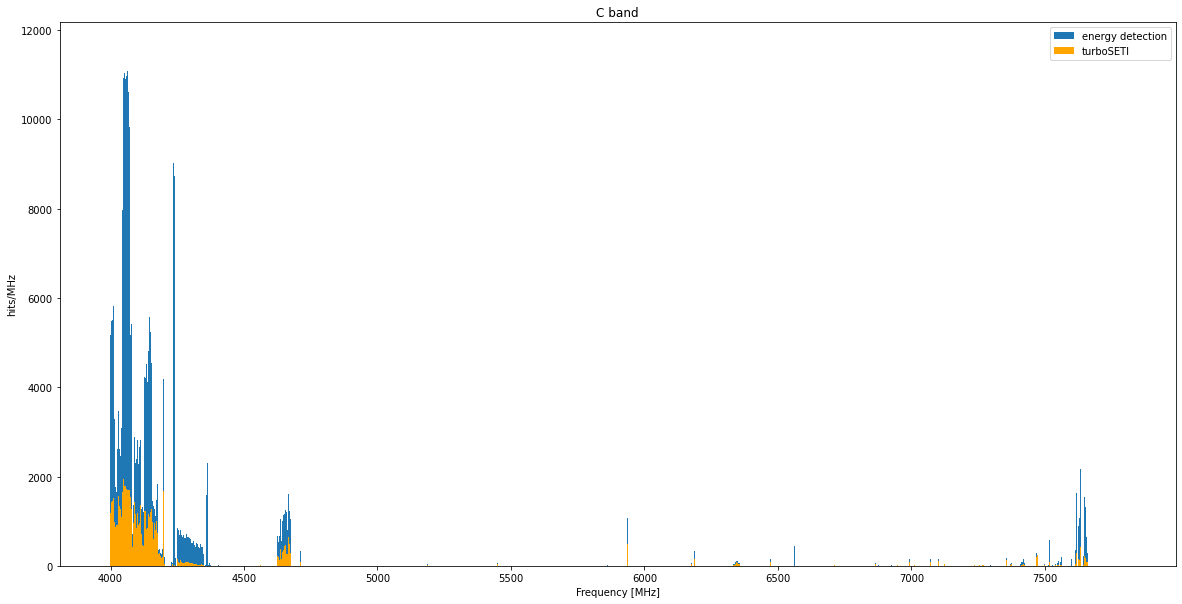

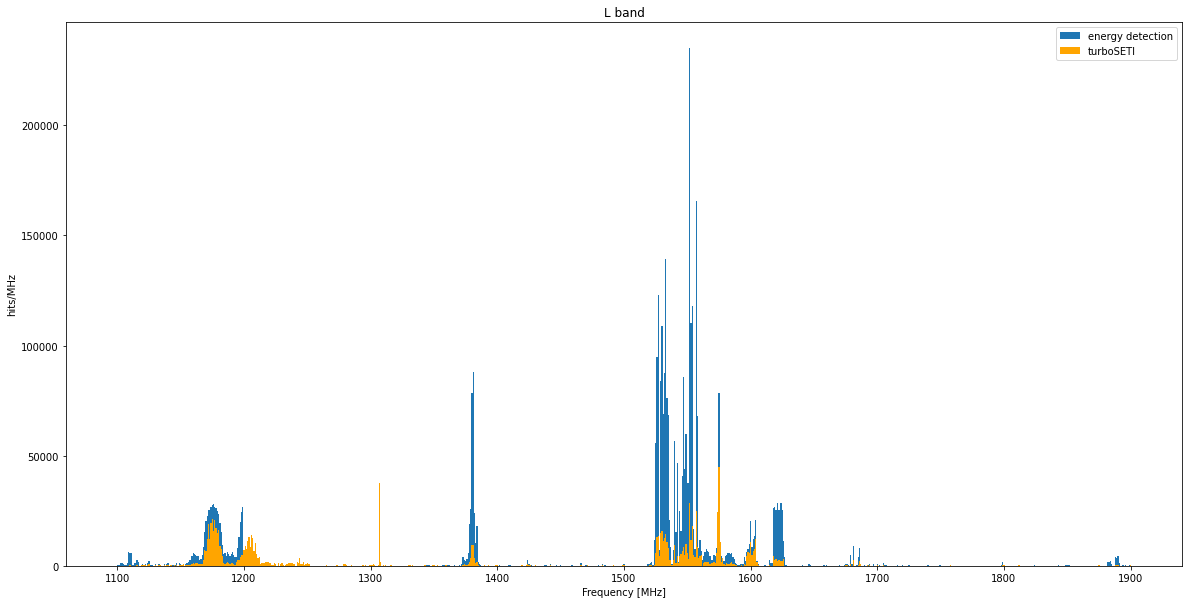

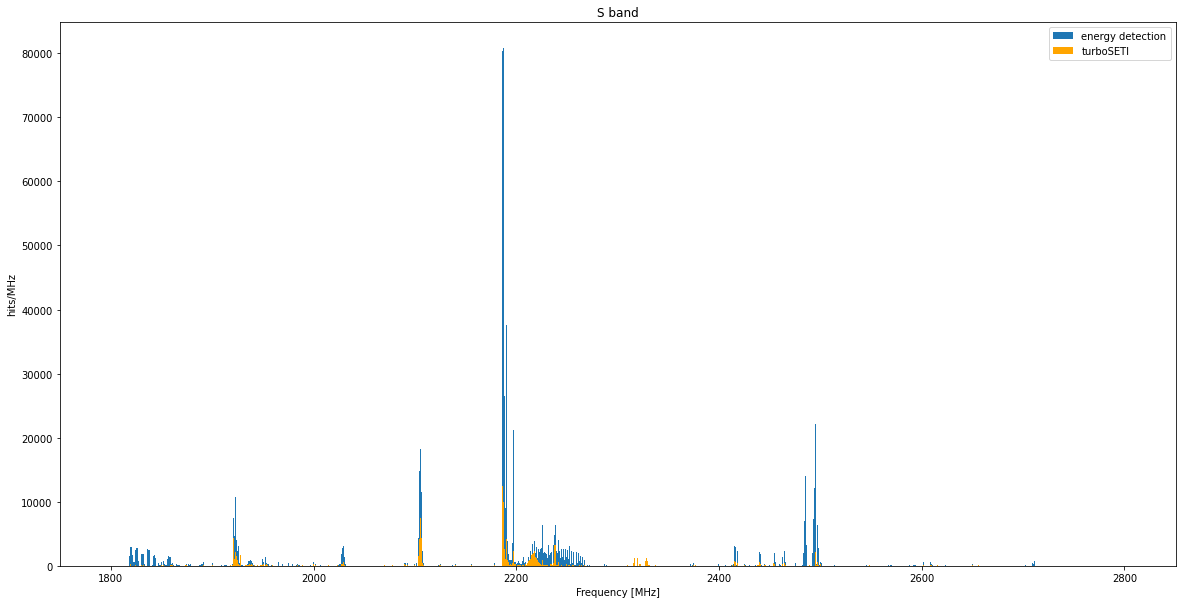

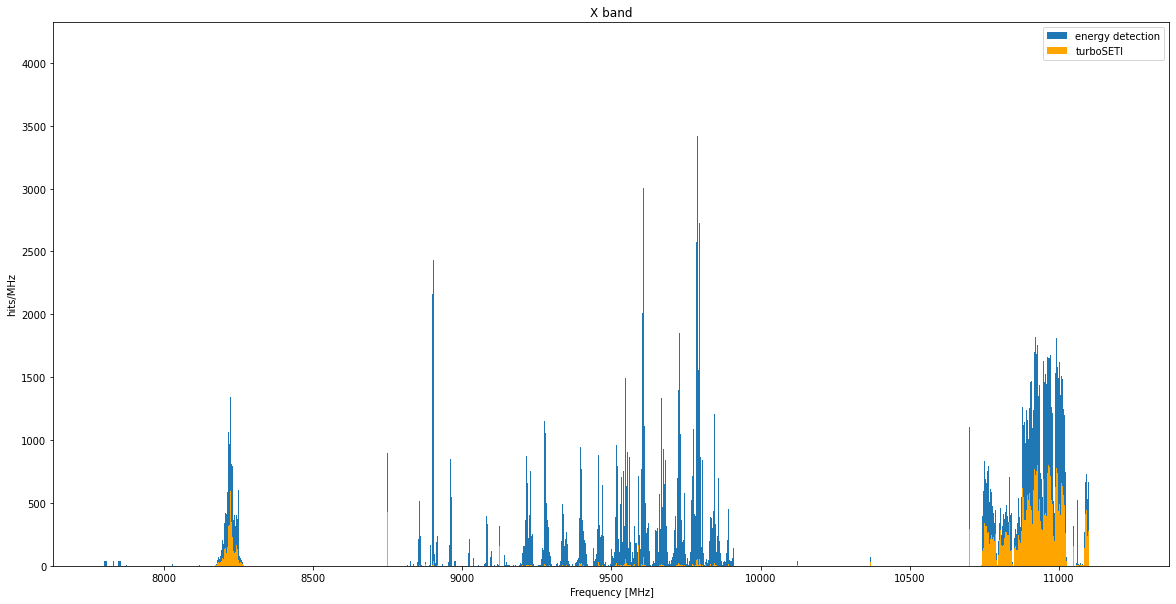

In [20]:
for i in range(4):
    hist = pd.read_csv(csv_files[i])
    dat_hist = pd.read_csv(dat_csvs[i])

    plt.figure(figsize=(20,10))
    plt.bar(hist["frequency"], hist["count"], width=1, label="energy detection")
    plt.bar(dat_hist["frequency"], dat_hist["count"], width=1, label="turboSETI", color="orange")
    plt.legend()
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("hits/MHz")
    plt.title(titles[i])
    plt.show();

# Identifying strange files

## Via Statistics

In [21]:
all_hist_csvs = glob.glob("/home/danielb/fall_2021/histograms/energy_detection_csvs/*ALL*csv")

In [22]:
all_hist_csvs

['/home/danielb/fall_2021/histograms/energy_detection_csvs/L_band_ALL_energy_detection_hist_threshold_4096.csv',
 '/home/danielb/fall_2021/histograms/energy_detection_csvs/X_band_ALL_energy_detection_hist_threshold_4096.csv',
 '/home/danielb/fall_2021/histograms/energy_detection_csvs/L_band_ALL_energy_detection_hist_threshold_4096_with_notch_data.csv',
 '/home/danielb/fall_2021/histograms/energy_detection_csvs/S_band_ALL_energy_detection_hist_threshold_4096.csv',
 '/home/danielb/fall_2021/histograms/energy_detection_csvs/C_band_ALL_energy_detection_hist_threshold_4096.csv',
 '/home/danielb/fall_2021/histograms/energy_detection_csvs/S_band_ALL_energy_detection_hist_threshold_4096_with_notch_data.csv']

In [23]:
band = pd.read_csv(all_hist_csvs[2], index_col="filename")

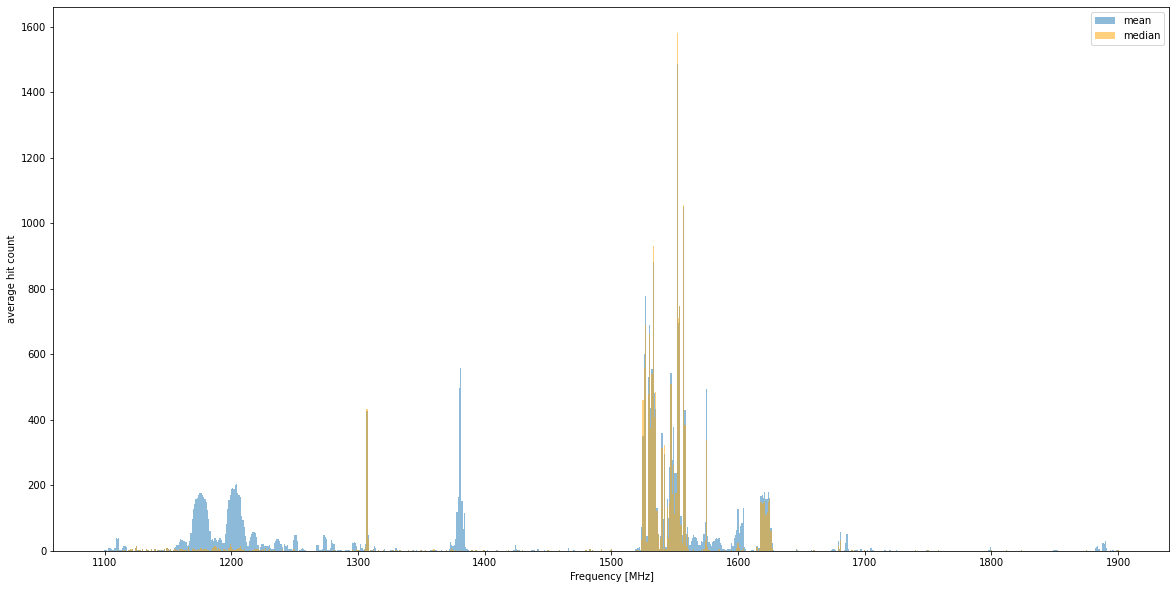

In [24]:
def table_statistics(df):
    data_array = df.to_numpy()
    mean = np.mean(data_array, axis=0)
    sd = np.std(data_array, axis=0)
    median = np.median(data_array, axis=0)
    return mean, sd, median

# band = pd.read_csv(all_hist_csvs[3], index_col="filename")
frequencies = np.asarray(band.columns).astype(float)
mean, sd, median = table_statistics(band)

plt.figure(figsize=(20,10))
plt.bar(frequencies, mean, width=1, label="mean", alpha=0.5)
plt.bar(frequencies, median, width=1, label="median", color="orange", alpha=0.5)
plt.legend()
plt.xlabel("Frequency [MHz]")
plt.ylabel("average hit count")
plt.show()

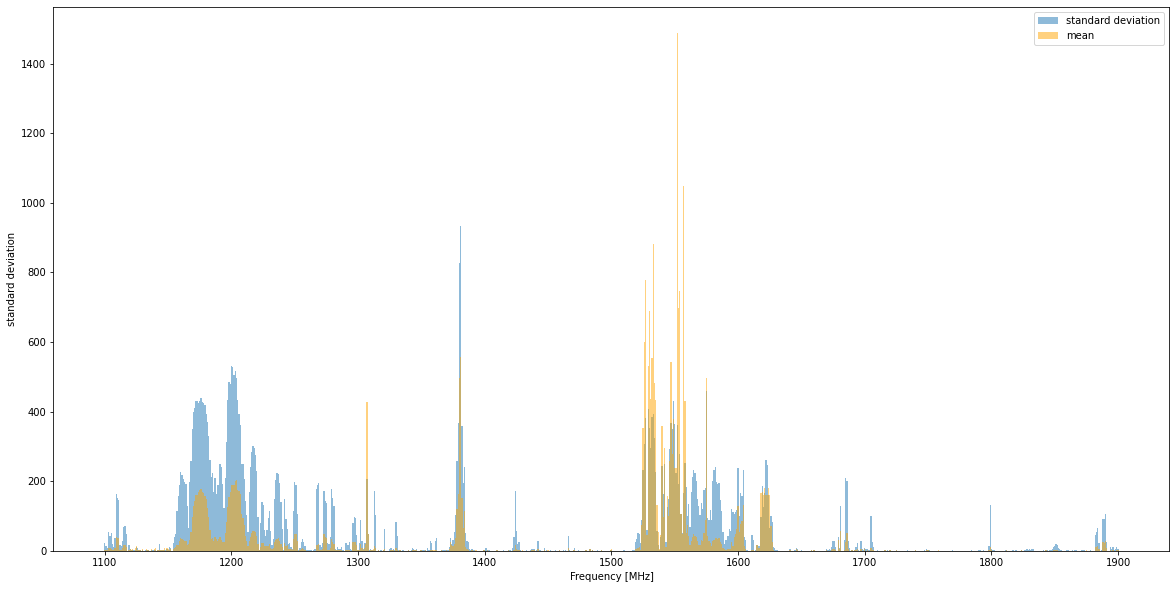

In [25]:
plt.figure(figsize=(20,10))
plt.bar(frequencies, sd, width=1, label="standard deviation", alpha=0.5)
plt.bar(frequencies, mean, width=1, label="mean", color="orange", alpha=0.5)
plt.legend()
plt.xlabel("Frequency [MHz]")
plt.ylabel("standard deviation")
plt.show()

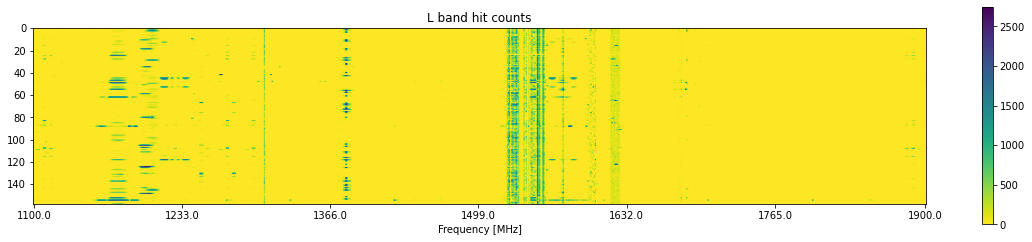

In [26]:
savedir = "/home/danielb/fall_2021/GBT_heatmaps/csv/"
band = pd.read_csv(all_hist_csvs[2], index_col="filename")

plt.figure(figsize=(20,4))
plt.imshow(band, cmap="viridis_r")
plt.colorbar()

freqs = band.columns.astype(float)
ticks = np.arange(len(band.columns))
step_size = int(len(ticks)/6)
indices = []
for i in np.arange(6):
    indices.append(i*step_size)
indices.append(len(ticks)-1)
plt.xticks(ticks=indices, labels=freqs[indices])
plt.xlabel("Frequency [MHz]");
plt.title("L band hit counts")
plt.show()

In [27]:
band

,1100.0,1101.0,1102.0,1103.0,1104.0,1105.0,1106.0,1107.0,1108.0,1109.0,...,1891.0,1892.0,1893.0,1894.0,1895.0,1896.0,1897.0,1898.0,1899.0,1900.0
filename,,,,,,,,,,,,,,,,,,,,,
spliced_blc0001020304050607_guppi_58873_11670_HIP79217_0051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
spliced_blc4041424344454647_guppi_58844_33730_HIP66263_0099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0
spliced_blc4041424344454647_guppi_58844_32460_HIP65076_0095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0
spliced_blc4041424344454647_guppi_58844_31162_HIP66570_0091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0
spliced_blc4041424344454647_guppi_58885_58845_TIC233087860_0041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spliced_blc4041424344454647_guppi_58844_28568_HIP74409_0083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0
spliced_blc5051525354555657_guppi_58892_34148_TIC35009898_0022,150.0,158.0,90.0,79.0,54.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,4.0,30.0,53.0,32.0,39.0
spliced_blc4041424344454647_guppi_58844_24040_HIP81872_0069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0


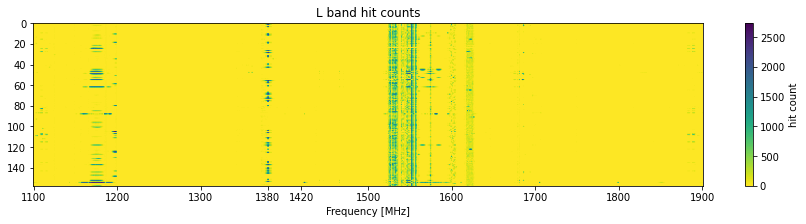

In [28]:
savedir = "/home/danielb/fall_2021/GBT_heatmaps/csv/"

band = pd.read_csv(all_hist_csvs[2], index_col="filename")
mask = np.where((freqs >=1200) & (freqs<= 1341))
band_data = band.to_numpy()
band_data[:, mask] = 0

plt.figure(figsize=(15,3))
plt.imshow(band, cmap="viridis_r", aspect="auto")
plt.colorbar(label="hit count")

n_ticks = 9

freqs = np.arange(1100, 1900.1)
# ticks = np.linspace(1100, 1900, num=n_ticks)
ticks = np.asarray([1100, 1200, 1300, 1380, 1420, 1500, 1600, 1700, 1800, 1900])
indices = (np.where(np.in1d(freqs, ticks) == True)[0])#, len(band))
plt.xticks(ticks=indices, labels=freqs[indices].astype(int))
plt.xlabel("Frequency [MHz]");
plt.title("L band hit counts")
plt.savefig(savedir + "L_band.pdf", bbox_inches="tight", transparent=False)
plt.show()

In [29]:
np.mean(band["1420.0"]), np.std(band["1420.0"]), np.median(band["1420.0"])

(0.569620253164557, 1.0272680286214422, 0.0)

In [30]:
np.min(band["1420.0"]), np.max(band["1420.0"])

(0.0, 6.0)

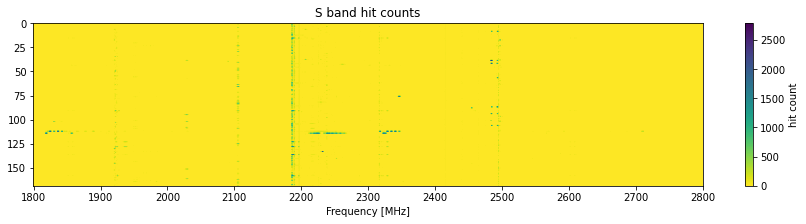

In [31]:
savedir = "/home/danielb/fall_2021/GBT_heatmaps/csv/"

band = pd.read_csv(all_hist_csvs[5], index_col="filename")
freqs = np.arange(1800, 2800.1)
band_data = band.to_numpy()
mask = np.where((freqs <= 2300) & (freqs >= 2360))
band_data[:, mask] = 0

plt.figure(figsize=(15,3))
plt.imshow(band, cmap="viridis_r", aspect="auto")
plt.colorbar(label="hit count")

n_ticks = 11

ticks = np.arange(1800, 2800.1, 100)
indices = (np.where(np.in1d(freqs, ticks) == True)[0])#, len(band))
plt.xticks(ticks=indices, labels=freqs[indices].astype(int))
plt.xlabel("Frequency [MHz]");
plt.title("S band hit counts")
plt.savefig(savedir + "S_band.pdf", bbox_inches="tight", transparent=False)
plt.show()

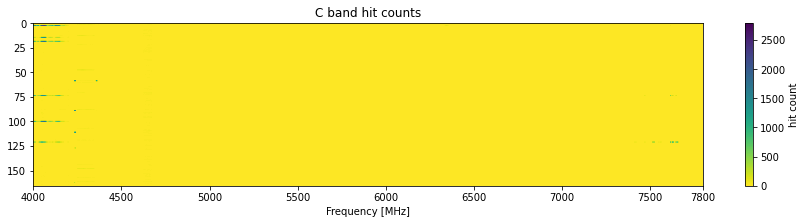

In [32]:
savedir = "/home/danielb/fall_2021/GBT_heatmaps/csv/"

band = pd.read_csv(all_hist_csvs[4], index_col="filename")
freqs = np.arange(4000, 7800.1)
band_data = band.to_numpy()

plt.figure(figsize=(15,3))
plt.imshow(band, cmap="viridis_r", aspect="auto")
plt.colorbar(label="hit count")

ticks = np.asarray([4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 7800])
indices = (np.where(np.in1d(freqs, ticks) == True)[0])#, len(band))
plt.xticks(ticks=indices, labels=freqs[indices].astype(int))
plt.xlabel("Frequency [MHz]");
plt.title("C band hit counts")
plt.savefig(savedir + "C_band.pdf", bbox_inches="tight", transparent=False)
plt.show()

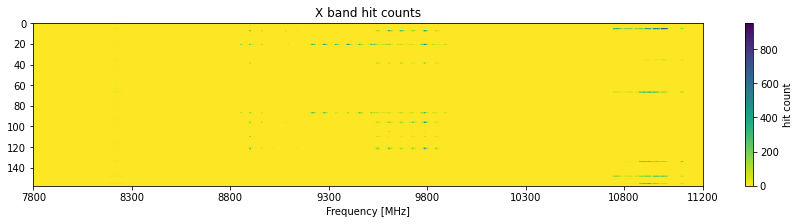

In [33]:
savedir = "/home/danielb/fall_2021/GBT_heatmaps/csv/"

band = pd.read_csv(all_hist_csvs[1], index_col="filename")
freqs = np.arange(7800, 11200.1)
band_data = band.to_numpy()

plt.figure(figsize=(15,3))
plt.imshow(band, cmap="viridis_r", aspect="auto")
plt.colorbar(label="hit count")

ticks = np.append(np.arange(7800, 11200.1, 500), 11200)
indices = (np.where(np.in1d(freqs, ticks) == True)[0])#, len(band))
plt.xticks(ticks=indices, labels=freqs[indices].astype(int))
plt.xlabel("Frequency [MHz]");
plt.title("X band hit counts")
plt.savefig(savedir + "X_band.pdf", bbox_inches="tight", transparent=False)
plt.show()

In [34]:
def z_score(df):
    arr = np.array(df)
    mean = np.mean(arr, axis=0)
    sd = np.std(arr, axis=0)
    no_data = np.where(np.sum(arr, axis=0) == 0)
    # correct for zero standard deviations
    sd[no_data] = np.inf
    mask = np.where(sd==0)
    sd[mask] = 1e-9
    z_tbl = (arr - mean)/sd
    
    return z_tbl

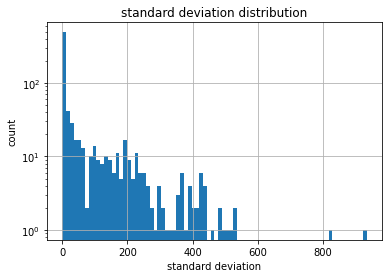

In [35]:
plt.figure()
hist, bin_edges, _ = plt.hist(sd, bins=80)
plt.yscale("log")
plt.grid()
plt.xlabel("standard deviation")
plt.ylabel("count")
plt.title("standard deviation distribution");

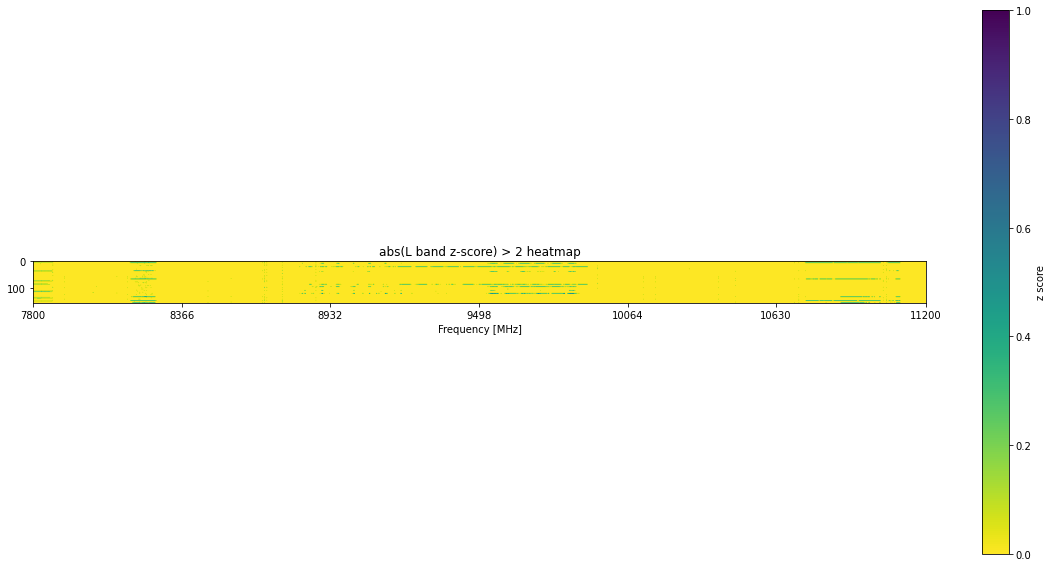

In [36]:
z_val = 2

plt.figure(figsize=(20,10))
plt.imshow(np.abs(z_score(band)) > z_val, cmap="viridis_r")
plt.colorbar(label="z score")
plt.title("abs(L band z-score) > %s heatmap"%z_val)
freqs = np.array(band.columns.astype(float), dtype=int)
ticks = np.arange(band.shape[1])
step_size = int(len(ticks)/6)
indices = []
for i in np.arange(6):
    indices.append(i*step_size)
indices.append(len(ticks)-1)
plt.xticks(ticks=indices, labels=freqs[indices])
plt.xlabel("Frequency [MHz]");
plt.savefig("lband_heatmap.pdf")

### Different measures of spread

The standard deviation of the data is far higher than the average frequency itself

The median absolute deviation is a better metric to be working with. For the majority of the bins, it has a value of zero, and only has a high value for frequencies around 8250MHz

In [ ]:
# med_abs_dev = stats.median_abs_deviation(band.values, axis=0)
# st_dev = np.std(band.values, axis=0)
# freq_bins = np.array(band.columns)

# plt.figure(figsize=(20,10))
# plt.bar(frequencies, fractions, width=1, label="fine channel fraction")
# plt.bar(freq_bins, med_abs_dev, width=1, label="median absolute deviation", color="orange")
# # plt.bar(freq_bins, st_dev, width=1, label="standard deviation", color="crimson", alpha=0.5)
# plt.xlabel("Frequency [MHz]")
# plt.ylabel("fine channels / MHz")
# plt.title("xband")
# plt.legend();

In [ ]:
def high_z_score(df, min_z):
    # want to identify flagged frequencies as well as file names
    z_tbl = z_score(df)
    bad_mask = np.where(np.abs(z_tbl) > min_z)[0]
    bad_mask = np.unique(bad_mask)
    flagged_files =  df.iloc[bad_mask]
    return flagged_files.index

def high_mean(df, min_mean):
    arr = np.array(df)
    bad_mask = np.where(arr > min_mean)[0]
    bad_mask = np.unique(bad_mask)
    flagged_files =  df.iloc[bad_mask]
    return flagged_files.index

In [ ]:
def flag_z(df, min_z, region="upper"):
    """
    Takes a DataFrame and minimum Z-score and returns 
    all the files with channels above this Z-score
    as well as the corresponding frequencies
    
    Will output two lists of the same length. The 
    first file will hold the filenames and the second 
    will hold the frequencies in that file that are 
    above the Z-score
    
    Arguments:
    -----------
    df : pandas.core.frame.DataFrame
        DataFrame containing the fine channel fraction data
    min_z : float
        the minimum allowed Z-score, above which files will
        be flagged
        
    Returns:
    ---------
    flagged_files : pandas.core.indexes.base.Index
        An array containing strings of the filenames
        of the flagged files
    flagged_freqs : list
        A list of frequencies that were flagged 
    """
    z_tbl = z_score(df)
    if region=="upper":
        mask = np.where(z_tbl > min_z)
    else:
        mask = np.where(z_tbl < min_z)
    stacked = np.vstack(mask)
    file_indx = np.unique(stacked[0])
    flagged_freqs = []
    for indx in file_indx:
        this_file = stacked[1][np.where(stacked[0] == indx)[0]]
        frequencies = np.array(df.T.iloc[this_file].index)
        flagged_freqs.append(frequencies)
    flagged_files = df.iloc[file_indx].index
    return flagged_files, flagged_freqs

In [ ]:
band = pd.read_csv(all_hist_csvs[2], index_col="filename")
mask = np.where((freqs >=1200) & (freqs<= 1341))
band_data = band.to_numpy()
band_data[:, mask] = 0

In [ ]:
a, b = flag_z(band, 2)
a

In [ ]:
savedir = "/home/danielb/fall_2021/flags_for_noah/"
filename = savedir + "flagged_files_2SD.pkl"
save_dict = {"file name":a, "flagged frequency":b}
with open(filename, "wb") as f:
    pickle.dump(save_dict, f)

In [ ]:
with open(filename, "rb") as f:
    pickled_contents = pickle.load(f)

In [ ]:
percent_flagged = []
all_flags = np.array([], dtype=float)
for arr in b:
    percent_flagged.append(len(arr)/len(frequencies))
    all_flags = np.append(all_flags, arr.astype(float))
most_flags = np.argmax(percent_flagged)

In [ ]:
len(b[most_flags])/len(frequencies)

In [ ]:
plot_path = savedir + "lband_hit_frequency.pdf"

plt.figure(figsize=(10,7))
_ = plt.hist(all_flags, bins=800)
plt.xlabel("Frequency [MHz]")
plt.ylabel("number of times flagged")
plt.title("L Band files with hit counts 2$\sigma$ above the mean")
plt.savefig(plot_path, bbox_inches="tight", transparent=False)
# plt.yscale("log")

In [ ]:
missing_file = "spliced_blc4041424344454647_guppi_58885_59483_TIC233087860_0043"
np.where(band.index == missing_file)
np.where(a == missing_file)

In [ ]:
gps = [missing_file, 
            'spliced_blc4041424344454647_guppi_58885_60119_TIC233087860_0045',
            'spliced_blc4041424344454647_guppi_58885_58845_TIC233087860_0041']

mask = np.where((band.index == gps[0]) | (band.index == gps[1]) | (band.index == gps[2]))
a[mask]

In [ ]:
mask

In [ ]:
b[4], b[11], b[111]

# Counts of bins above a 2$\sigma$ threshold

In [50]:
all_hist_csvs

['/home/danielb/fall_2021/histograms/energy_detection_csvs/L_band_ALL_energy_detection_hist_threshold_4096.csv',
 '/home/danielb/fall_2021/histograms/energy_detection_csvs/X_band_ALL_energy_detection_hist_threshold_4096.csv',
 '/home/danielb/fall_2021/histograms/energy_detection_csvs/L_band_ALL_energy_detection_hist_threshold_4096_with_notch_data.csv',
 '/home/danielb/fall_2021/histograms/energy_detection_csvs/S_band_ALL_energy_detection_hist_threshold_4096.csv',
 '/home/danielb/fall_2021/histograms/energy_detection_csvs/C_band_ALL_energy_detection_hist_threshold_4096.csv',
 '/home/danielb/fall_2021/histograms/energy_detection_csvs/S_band_ALL_energy_detection_hist_threshold_4096_with_notch_data.csv']

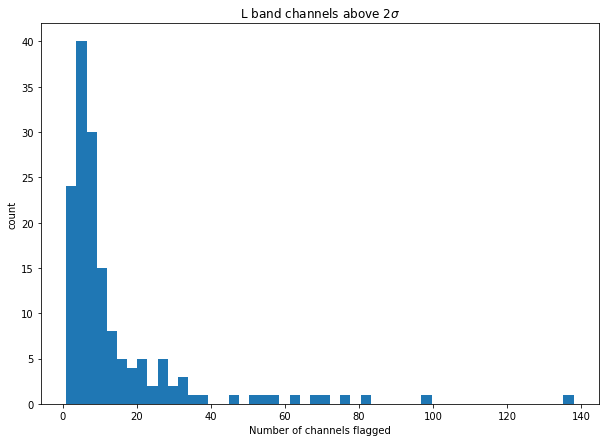

In [68]:
# L band 
sigma_threshold = 2

band = pd.read_csv(all_hist_csvs[2], index_col="filename")
freqs = np.arange(1100, 1901)
mask = np.where((freqs >=1200) & (freqs<= 1341))
band_data = band.to_numpy()
band_data[:, mask] = 0

a, b = flag_z(band, sigma_threshold)
flag_counts = []
for entry in b:
    flag_counts.append(len(entry))
    
plt.figure(figsize=(10,7))
_ = plt.hist(flag_counts, bins=50)
plt.title("L band channels above %s$\sigma$"%sigma_threshold)
plt.xlabel("Number of channels flagged")
plt.ylabel("count")
plt.show()

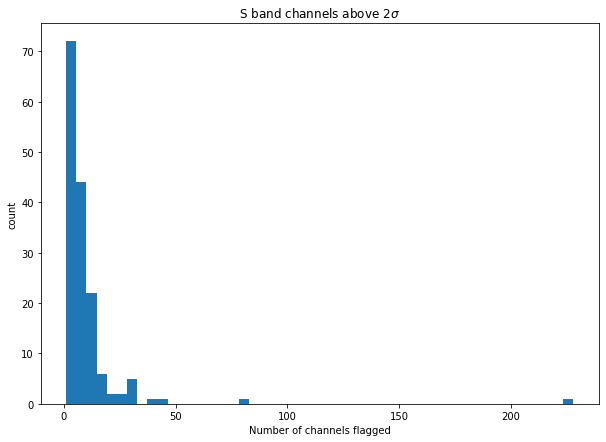

In [71]:
# S band
sigma_threshold = 2

band = pd.read_csv(all_hist_csvs[5], index_col="filename")
freqs = np.arange(1800, 2801)
mask = np.where((freqs >= 2300) & (freqs <= 2360))
band_data = band.to_numpy()
band_data[:, mask] = 0

a, b = flag_z(band, sigma_threshold)
flag_counts = []
for entry in b:
    flag_counts.append(len(entry))
    
plt.figure(figsize=(10,7))
_ = plt.hist(flag_counts, bins=50)
plt.title("S band channels above %s$\sigma$"%sigma_threshold)
plt.xlabel("Number of channels flagged")
plt.ylabel("count")
plt.show()

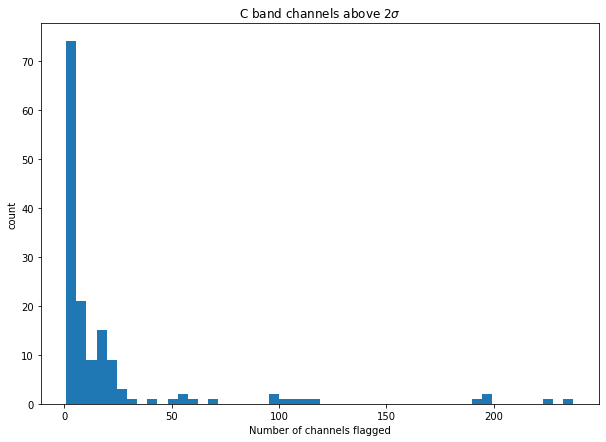

In [72]:
# C band
sigma_threshold = 2

band = pd.read_csv(all_hist_csvs[4], index_col="filename")

a, b = flag_z(band, sigma_threshold)
flag_counts = []
for entry in b:
    flag_counts.append(len(entry))
    
plt.figure(figsize=(10,7))
_ = plt.hist(flag_counts, bins=50)
plt.title("C band channels above %s$\sigma$"%sigma_threshold)
plt.xlabel("Number of channels flagged")
plt.ylabel("count")
plt.show()

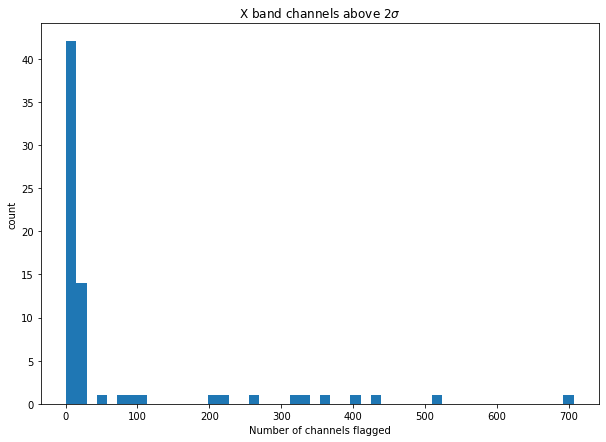

In [73]:
# X band
sigma_threshold = 2

band = pd.read_csv(all_hist_csvs[1], index_col="filename")

a, b = flag_z(band, sigma_threshold)
flag_counts = []
for entry in b:
    flag_counts.append(len(entry))
    
plt.figure(figsize=(10,7))
_ = plt.hist(flag_counts, bins=50)
plt.title("X band channels above %s$\sigma$"%sigma_threshold)
plt.xlabel("Number of channels flagged")
plt.ylabel("count")
plt.show()

### Testing some code, can delete later

In [76]:
band.head()

,7800.0,7801.0,7802.0,7803.0,7804.0,7805.0,7806.0,7807.0,7808.0,7809.0,...,11191.0,11192.0,11193.0,11194.0,11195.0,11196.0,11197.0,11198.0,11199.0,11200.0
filename,,,,,,,,,,,,,,,,,,,,,
spliced_blc00010203040506o7o0111213141516o7o021222324252627_guppi_58810_14835_HIP94609_0038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
spliced_blc00010203040506o7o0111213141516o7o021222324252627_guppi_58810_14512_TIC284450803_0037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
spliced_blc40414243444546o7o0515253545556o7o061626364656667_guppi_58888_79017_TIC266500992_0031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
spliced_blc00010203040506o7o0111213141516o7o021222324252627_guppi_58806_21195_TIC349827430_0053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
spliced_blc40414243444546o7o0515253545556o7o061626364656667_guppi_58888_79336_HIP18962_0032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
(band.to_numpy()).shape

(158, 3401)

In [97]:
all_hist_csvs

['/home/danielb/fall_2021/histograms/energy_detection_csvs/L_band_ALL_energy_detection_hist_threshold_4096.csv',
 '/home/danielb/fall_2021/histograms/energy_detection_csvs/X_band_ALL_energy_detection_hist_threshold_4096.csv',
 '/home/danielb/fall_2021/histograms/energy_detection_csvs/L_band_ALL_energy_detection_hist_threshold_4096_with_notch_data.csv',
 '/home/danielb/fall_2021/histograms/energy_detection_csvs/S_band_ALL_energy_detection_hist_threshold_4096.csv',
 '/home/danielb/fall_2021/histograms/energy_detection_csvs/C_band_ALL_energy_detection_hist_threshold_4096.csv',
 '/home/danielb/fall_2021/histograms/energy_detection_csvs/S_band_ALL_energy_detection_hist_threshold_4096_with_notch_data.csv']

In [100]:
type(band)

pandas.core.frame.DataFrame

In [99]:
band = pd.read_csv(all_hist_csvs[4], index_col="filename")

def sort_flags(band, ):
    indices = list(band.index)
    flag_count = np.sum((z_score(band) >= 2), axis=1)

    data_dict = {"filename":indices, "flagged bins":flag_count}
    test_df = pd.DataFrame(data_dict)
    return test_df.sort_values("flagged bins")

sort_flags(band)

,filename,flagged bins
87,spliced_blc30313233343536o7o0414243444546o7o05...,0
36,spliced_blc1011121314151617_guppi_58860_69807_...,0
99,spliced_blc30313233343536o7o0414243444546o7o05...,0
34,spliced_blc10111213141516o7o0212223242526o7o03...,0
62,spliced_blc30313233343536o7o0414243444546o7o05...,0
...,...,...
74,spliced_blc30313233343536o7o0414243444546o7o05...,191
19,spliced_blc30313233343536o7o0414243444546o7o05...,195
100,spliced_blc30313233343536o7o0414243444546o7o05...,197
121,spliced_blc30313233343536o7o0414243444546o7o05...,223


# Looking at the files with the most/least flags

In [104]:
c_path = glob.glob("/home/gcsfuse/blpc0/bl_tess/x_band/*0.h5")
c_path[-1]

'/home/gcsfuse/blpc0/bl_tess/x_band/spliced_blco0010203040506o7o01112131415161770717273747576o7_guppi_58859_00306_HIP98379_0039.gpuspec.0000.h5'

In [105]:
dummy = bl.Waterfall(c_path[-1], f_start=7800, f_stop=11200)
del dummy

blimpy.io.base_reader WARNING  Setting f_stop = 11102.050781, since f_stop not given or not valid.
blimpy.io.base_reader WARNING  Selection size of 70.44 GB, exceeding our size limit 1.00 GB. Instance created, header loaded, but data not loaded, please try another (t,v) selection.


In [115]:
def spectrum_and_waterfall(h5_path, f_start, f_stop, spectrum_path, waterfall_path, max_load=1, show=True):
    hf = bl.Waterfall(h5_path, f_start=f_start, f_stop=f_stop, max_load=max_load)
    print("data loaded")
    plt.figure(figsize=(20,10))
    hf.plot_spectrum()
    plt.tight_layout()
    plt.savefig(spectrum_path, bbox_inches='tight', transparent=False)

    plt.figure(figsize=(20,10))
    hf.plot_waterfall()
    plt.tight_layout()
    plt.savefig(waterfall_path, bbox_inches='tight', transparent=False)
    del hf
    gc.collect()
    if not show:
        plt.close("all")
    return 

In [104]:
band = pd.read_csv(all_hist_csvs[5], index_col="filename")
band.columns

Index(['1800.0', '1801.0', '1802.0', '1803.0', '1804.0', '1805.0', '1806.0',
       '1807.0', '1808.0', '1809.0',
       ...
       '2791.0', '2792.0', '2793.0', '2794.0', '2795.0', '2796.0', '2797.0',
       '2798.0', '2799.0', '2800.0'],
      dtype='object', length=1001)

In [128]:
band = pd.read_csv(all_hist_csvs[5], index_col="filename")
# mask = np.where((freqs >=1200) & (freqs<= 1341))
freqs = np.arange(1800, 2801)
mask = np.where((freqs >= 2300) & (freqs <= 2360))
band_data = band.to_numpy()
band_data[:, mask] = 0

a, b = flag_z(band, -2, region="lower")

In [129]:
percent_flagged = []
all_flags = np.array([], dtype=float)
for arr in b:
    percent_flagged.append(len(arr)/len(freqs))
    all_flags = np.append(all_flags, arr.astype(float))
most_flags = np.argmax(percent_flagged)

In [131]:
flag_dict = {"filename":a, "percent flagged":percent_flagged}
flag_df = pd.DataFrame(flag_dict)
top_5 = flag_df.sort_values("percent flagged", ascending=False)[:5]
bottom_5 = flag_df.sort_values("percent flagged", ascending=True)[:5]
top_5

,filename,percent flagged
62,spliced_blc7071727374757677_guppi_58814_43898_...,0.019980
38,spliced_blc0001020304050607_guppi_58819_72038_...,0.019980
29,spliced_blc0001020304050607_guppi_58819_72177_...,0.019980
0,spliced_blc7071727374757677_guppi_58814_44040_...,0.018981
18,spliced_blc0001020304050607_guppi_58819_65716_...,0.005994


In [132]:
# total_count = band.copy()
# data_arr = total_count.to_numpy()
# sum_hits = np.sum(data_arr, axis=1)
# sum_dict = {"filename":total_count.index, "total hits":sum_hits}
# total_count = pd.DataFrame(sum_dict)
# top_5 = total_count.sort_values("total hits", ascending=False)[:5]
# bottom_5 = total_count.sort_values("total hits")[:5]
# top_5

In [133]:
remaining = np.arange(5)

In [134]:
for i in remaining:
    file_path = glob.glob("/home/gcsfuse/blpc0/bl_tess/s_band/"+top_5.iloc[i]["filename"]+"*0.h5")
    bucket_path = "/".join(file_path[0].split("/")[4:])
    os.system("gsutil cp gs://%s /datax/scratch/danielb/bl_tess/"%bucket_path)

Copying gs://bl_tess/s_band/spliced_blc7071727374757677_guppi_58814_43898_3C295_0129.gpuspec.0000.h5...
- [1 files][  5.5 GiB/  5.5 GiB]   77.1 MiB/s                                   
Operation completed over 1 objects/5.5 GiB.                                      
Copying gs://bl_tess/s_band/spliced_blc0001020304050607_guppi_58819_72038_3C295_0091.gpuspec.0000.h5...
| [1 files][  5.5 GiB/  5.5 GiB]   68.3 MiB/s                                   
Operation completed over 1 objects/5.5 GiB.                                      
Copying gs://bl_tess/s_band/spliced_blc0001020304050607_guppi_58819_72177_3C295_0092.gpuspec.0000.h5...
\ [1 files][  5.5 GiB/  5.5 GiB]   82.6 MiB/s                                   
Operation completed over 1 objects/5.5 GiB.                                      
Copying gs://bl_tess/s_band/spliced_blc7071727374757677_guppi_58814_44040_3C295_0130.gpuspec.0000.h5...
/ [1 files][  5.5 GiB/  5.5 GiB]   73.8 MiB/s                                   
Operation comp

In [135]:
for i in trange(5):
    h5_path = glob.glob("/datax/scratch/danielb/bl_tess/"+top_5.iloc[i]["filename"]+"*0.h5")[0]
    f_start = 1800
    f_stop = 2800
    save_dir = "/home/danielb/fall_2021/flagged_plots/z_score_flag/SD_2/s_band/bottom_5/"
    spectrum_path = save_dir + os.path.basename(h5_path) + "_%s_to_%s_spectrum_rank_%s.pdf"%(f_start, f_stop, i)
    waterfall_path= save_dir + os.path.basename(h5_path) + "_%s_to_%s_waterfall_rank_%s.pdf"%(f_start, f_stop, i)
    
    spectrum_and_waterfall(h5_path, f_start, f_stop, 
                           spectrum_path=spectrum_path, 
                           waterfall_path=waterfall_path, 
                           max_load=19.3, 
                           show=False)

  0%|                                                                                                                                                                | 0/5 [00:00<?, ?it/s]

blimpy.io.base_reader WARNING  Setting f_start = 1818.457031, since f_start not given or not valid.
blimpy.io.base_reader WARNING  Setting f_stop = 2720.800781, since f_stop not given or not valid.
blimpy.io.base_reader WARNING  Setting data limit = 19.3 GB > 1 GB, please handle with care!
data loaded
extracting integration 0...


 20%|██████████████████████████████▍                                                                                                                         | 1/5 [00:58<03:54, 58.70s/it]

blimpy.io.base_reader WARNING  Setting f_start = 1818.457031, since f_start not given or not valid.
blimpy.io.base_reader WARNING  Setting f_stop = 2720.800781, since f_stop not given or not valid.
blimpy.io.base_reader WARNING  Setting data limit = 19.3 GB > 1 GB, please handle with care!
data loaded
extracting integration 0...


 40%|████████████████████████████████████████████████████████████▊                                                                                           | 2/5 [01:57<02:55, 58.52s/it]

blimpy.io.base_reader WARNING  Setting f_start = 1818.457031, since f_start not given or not valid.
blimpy.io.base_reader WARNING  Setting f_stop = 2720.800781, since f_stop not given or not valid.
blimpy.io.base_reader WARNING  Setting data limit = 19.3 GB > 1 GB, please handle with care!
data loaded
extracting integration 0...


 60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 3/5 [02:56<01:57, 58.91s/it]

blimpy.io.base_reader WARNING  Setting f_start = 1818.457031, since f_start not given or not valid.
blimpy.io.base_reader WARNING  Setting f_stop = 2720.800781, since f_stop not given or not valid.
blimpy.io.base_reader WARNING  Setting data limit = 19.3 GB > 1 GB, please handle with care!
data loaded
extracting integration 0...


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 4/5 [03:54<00:58, 58.65s/it]

blimpy.io.base_reader WARNING  Setting f_start = 1818.457031, since f_start not given or not valid.
blimpy.io.base_reader WARNING  Setting f_stop = 2720.800781, since f_stop not given or not valid.
blimpy.io.base_reader WARNING  Setting data limit = 19.3 GB > 1 GB, please handle with care!
data loaded
extracting integration 0...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:42<00:00, 104.52s/it]


# Via Filename

Taking a priori knowledge about how the spliced file names are generated, we can look for files that are missing large chunks of data due to node dropout. This will appear in the file name as a jump in the sequence of numbers

Note: x band file 0 has a very strange name

In [219]:
BAND = "x"

file_paths = glob.glob("/home/gcsfuse/blpc0/bl_tess/%s_band/*0.h5"%BAND)
file_name = os.path.basename(file_paths[45])# index 45 was a good one
file_name

'spliced_blc00010203040506o7o0111213141516o7o021222324252627_guppi_58806_22133_HIP52796_0056.gpuspec.0000.h5'

In [220]:
splice_string = file_name.split("_")[1].replace("blc", "")
splice_string

'00010203040506o7o0111213141516o7o021222324252627'

In [221]:
split_banks = splice_string.split("o")
print(len(split_banks))
split_banks

5


['00010203040506', '7', '0111213141516', '7', '021222324252627']

In [212]:
correct_sequence = '00010203040506o7o0111213141516o7o021222324252627'

In [213]:
correct_sequence[::2]

'0000000oo111111oo2222222'

In [214]:
correct_sequence[1::2]

'012345670123456701234567'

In [215]:
splice_string[::2]

'00000000oooooo1oo2222222'

In [216]:
splice_string[1::2]

'012345670123456701234567'

In [199]:
def missing_node(file_name, band=None):
    # may need to let files leave out data in the overlap region
    if band is None:
        print("Which band does this come from?")
        return
    band = band.lower()
    if band == "l" or band == "s":
        n_banks = 1
    elif band == "x":
        n_banks = 3
    elif band == "c":
        n_banks = 4
    else:
        print("I don't know that band")
        return
    file_name = os.path.basename(file_name)
    splice_string = file_name.split("_")[1].replace("blc", "")
    test_sequence = splice_string[1::2]
    correct_sequence = "01234567"*n_banks
    allowed_sequences = [correct_sequence, "01234567012345601234567"]
    if test_sequence in allowed_sequences:
        return False
    else:
        return True

In [207]:
BAND = "x"
file_paths = glob.glob("/home/gcsfuse/blpc0/bl_tess/%s_band/*0.h5"%BAND)

results = []
bad_files = []
for i, file in enumerate(file_paths):
    result = missing_node(file, band=BAND)
    results.append(result)
    if result:
        bad_files.append(os.path.basename(file))
        
bad_files

['spliced_blc00010203040506o7o0111213141516o0212224252627_guppi_58806_44811_HIP68589_0132.gpuspec.0000.h5',
 'spliced_blc00010203040506o7o0111213141516o0222324252627_guppi_58806_46297_HIP66308_0137.gpuspec.0000.h5',
 'spliced_blc00010203040506o7o0111213141516o7o0212223242627_guppi_58810_20178_HIP98100_0055.gpuspec.0000.h5',
 'spliced_blc00010203040506o7o0111213141516o7o0212224252627_guppi_58806_19083_TIC302518439_0046.gpuspec.0000.h5',
 'spliced_blc00010203040506o7o0111213141516o7o0212224252627_guppi_58806_25893_TIC160268701_0068.gpuspec.0000.h5',
 'spliced_blc00010203040506o7o0111213141516o7o0212224252627_guppi_58806_33792_TIC230088370_0097.gpuspec.0000.h5',
 'spliced_blc00010203040506o7o01112131416o7o021222324252627_guppi_58806_40722_HIP81940_0119.gpuspec.0000.h5']

# Plotting examples of strange files

In [188]:
os.path.basename(file_paths[45])

'spliced_blc00010203040506o7o0111213141516o7o021222324252627_guppi_58806_22133_HIP52796_0056.gpuspec.0000.h5'

In [186]:
file_paths[45] in bad_files

False

blimpy.io.base_reader WARNING  Setting data limit = 6.5 GB > 1 GB, please handle with care!
data loaded
extracting integration 0...


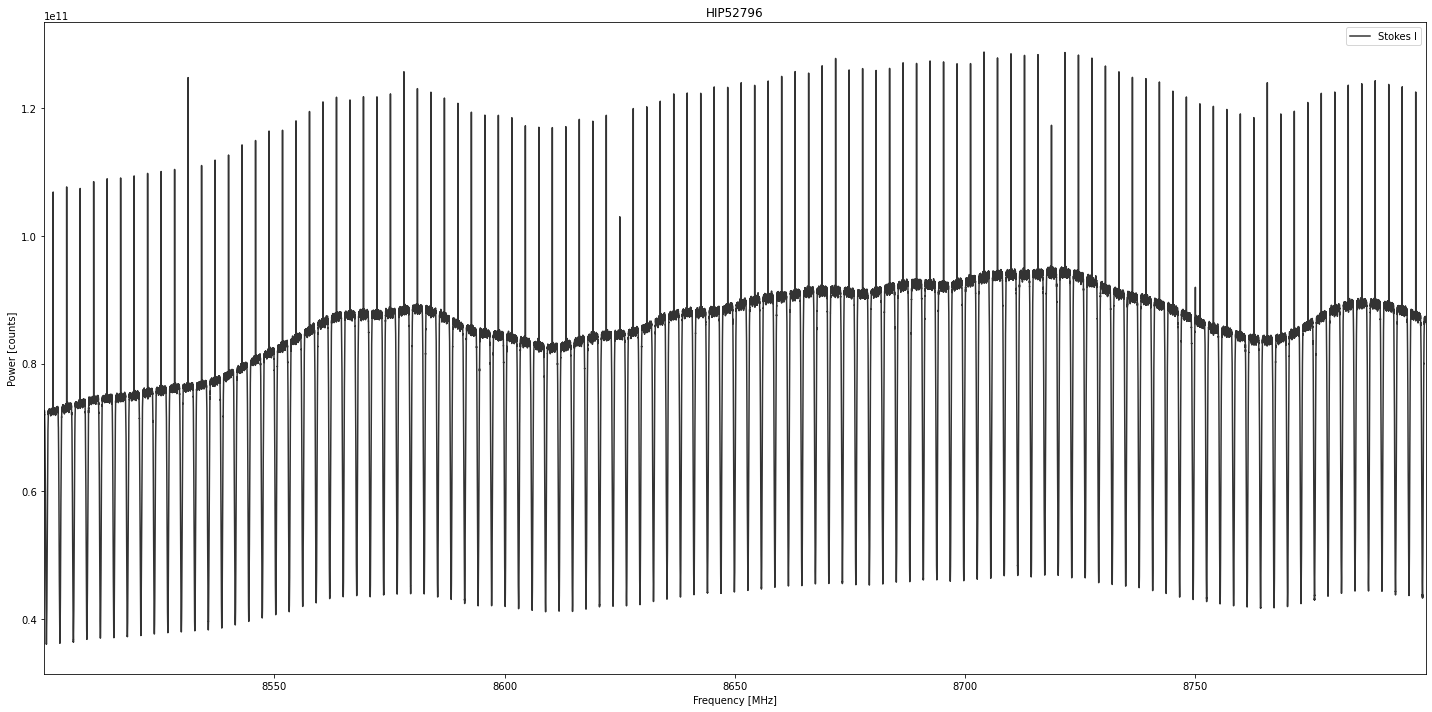

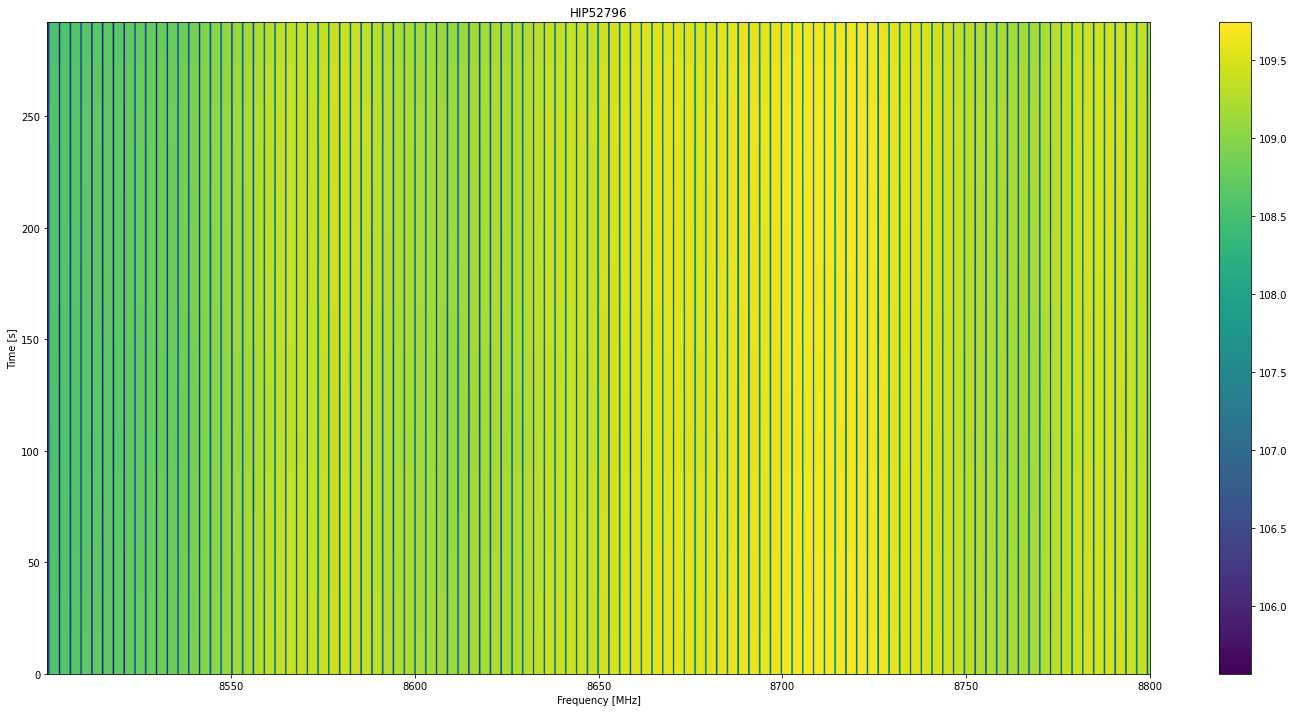

In [187]:
h5_path = file_paths[45]
f_start = 8500
f_stop = 8800

save_dir = "/home/danielb/fall_2021/flagged_plots/filename_flag/"
spectrum_path = save_dir + "spectrum/" + os.path.basename(h5_path) + "_%s_to_%s_spectrum.pdf"%(f_start, f_stop)
waterfall_path= save_dir + "waterfall/" + os.path.basename(h5_path) + "_%s_to_%s_waterfall.pdf"%(f_start, f_stop)

spectrum_and_waterfall(h5_path, f_start, f_stop, 
                       spectrum_path=spectrum_path, 
                       waterfall_path=waterfall_path, 
                       max_load=6.5)

In [146]:
dir_path = "/home/gcsfuse/blpc0/bl_tess/x_band/"
# h5_path = glob.glob(dir_path + a[index] + "*0.h5")[0]
f_start = 8553.75
f_stop = 8554.25

save_dir = "/home/danielb/fall_2021/flagged_plots/z_score_flag/"
# spectrum_path = save_dir + "spectrum/" + a[index] + "_%s_to_%s_spectrum.pdf"%(f_start, f_stop)
# waterfall_path = save_dir + "waterfall/" + a[index] + "_%s_to_%s_waterfall.pdf"%(f_start, f_stop)
    
# spectrum_and_waterfall(h5_path, f_start, f_stop, spectrum_path, waterfall_path)

In [42]:
total = 0
for i in range(len(b)):
    total += len(b[i])
total*2/60

94.46666666666667

In [43]:
def batch_and_plot(h5_path, flagged_freqs, save_dir, band=None):
    # Check for band data
    if band is None:
        print("Which band is this?")
        return
    
    if band.upper() == "X":
        span = 3400
        filesize = 60
    if band.upper() == "S":
        span = 1000
        filesize = 20
    if band.upper() == "C":
        span = 3800
        filesize = 70
    if band.upper() == "L":
        span = 800
        filesize = 20
    
    jumps = np.where(np.diff(flagged_freqs, n=2) != 0)
    splits = jumps[0][::2] + 2
    spectral_intervals = np.split(flagged_freqs, splits)
    
    file_name = os.path.basename(h5_path).split(".")[0]
    
    for interval in spectral_intervals:
        f_start = np.min(interval) - 0.5
        f_stop = np.max(interval) + 0.5
        freq_range = f_stop - f_start
        load_size = (filesize * (freq_range/span) + 0.1)*1.2
        batch_data = bl.Waterfall(h5_path, f_start=f_start, f_stop=f_stop, max_load=load_size)
        
        for freq in interval:
            plot_min = freq - 0.5
            plot_max = freq + 0.5
            spectrum_path = save_dir + "/" + file_name + "_%s_to_%s_spectrum.pdf"%(plot_min, plot_max)
            waterfall_path = save_dir + "/" + file_name + "_%s_to_%s_waterfall.pdf"%(plot_min, plot_max)
#             print(spectrum_path)
            
            # plot spectrum 
            plt.figure(figsize=(20,10))
            batch_data.plot_spectrum(f_start=plot_min, f_stop=plot_max)
            plt.tight_layout()
            plt.savefig(spectrum_path, bbox_inches='tight', transparent=False)
            
            # plot waterfall
            plt.figure(figsize=(20,10))
            batch_data.plot_waterfall(f_start=plot_min, f_stop=plot_max)
            plt.tight_layout()
            plt.savefig(waterfall_path, bbox_inches='tight', transparent=False)
            
            plt.close("all")
        del batch_data

In [44]:
b[1]

array([8899., 8900., 8963., 8964., 8965., 9547., 9549., 9552., 9555.,
       9556., 9559., 9595., 9600., 9601., 9602., 9603., 9604., 9605.,
       9606., 9607., 9608., 9609., 9610., 9611., 9612., 9613., 9614.,
       9615., 9616., 9617., 9618., 9619., 9620., 9621., 9622., 9623.,
       9624., 9625., 9626., 9627., 9628., 9629., 9632., 9650., 9655.,
       9656., 9659., 9660., 9661., 9662., 9663., 9664., 9665., 9666.,
       9667., 9668., 9669., 9670., 9671., 9672., 9673., 9674., 9675.,
       9676., 9677., 9678., 9679., 9680., 9681., 9682., 9683., 9684.,
       9685., 9686., 9687., 9688., 9689., 9717., 9725., 9727., 9728.,
       9733., 9734., 9738., 9742., 9743., 9750., 9759., 9792., 9794.,
       9798., 9799., 9802., 9803., 9806., 9841., 9847., 9849., 9851.,
       9853., 9859., 9860., 9864.])

In [45]:
jumps = np.where(np.diff(b[1], n=2) != 0)
splits = jumps[0][::2] + 2
spectral_intervals = np.split(b[1], splits)
spectral_intervals

[array([8899., 8900.]),
 array([8963., 8964., 8965.]),
 array([9547., 9549.]),
 array([9552., 9555., 9556.]),
 array([9559., 9595.]),
 array([9600., 9601., 9602., 9603., 9604., 9605., 9606., 9607., 9608.,
        9609., 9610., 9611., 9612., 9613., 9614., 9615., 9616., 9617.,
        9618., 9619., 9620., 9621., 9622., 9623., 9624., 9625., 9626.,
        9627., 9628., 9629.]),
 array([9632., 9650.]),
 array([9655., 9656.]),
 array([9659., 9660., 9661., 9662., 9663., 9664., 9665., 9666., 9667.,
        9668., 9669., 9670., 9671., 9672., 9673., 9674., 9675., 9676.,
        9677., 9678., 9679., 9680., 9681., 9682., 9683., 9684., 9685.,
        9686., 9687., 9688., 9689.]),
 array([9717., 9725.]),
 array([9727., 9728.]),
 array([9733., 9734.]),
 array([9738., 9742., 9743.]),
 array([9750., 9759.]),
 array([9792., 9794.]),
 array([9798., 9799.]),
 array([9802., 9803.]),
 array([9806., 9841.]),
 array([9847., 9849., 9851., 9853.]),
 array([9859., 9860.]),
 array([9864.])]

In [46]:
# for index in range(1, len(a)):
#     print("STARTING INDEX", index)
#     plot_dir = '/home/danielb/fall_2021/flagged_plots/z_score_flag/z_above_6/'
#     dir_path = "/home/gcsfuse/blpc0/bl_tess/x_band/"
#     h5_path = glob.glob(dir_path + a[index] + "*0.h5")[0]
#     save_dir = plot_dir + a[index]
#     if not os.path.exists(save_dir):
#         os.mkdir(save_dir)
#     batch_and_plot(h5_path, b[index], save_dir, "X")

In [47]:
# plot_dir = '/home/danielb/fall_2021/flagged_plots/z_score_flag/z_above_6/'

# for index in trange(len(a)):
#     file_name = a[index]
#     save_dir = plot_dir + file_name
#     if not os.path.exists(save_dir):
#         os.mkdir(save_dir)
#     dir_path = "/home/gcsfuse/blpc0/bl_tess/x_band/"
#     h5_path = glob.glob(dir_path + a[index] + "*0.h5")[0]
    
#     for wavelength in b[index]:
#         f_start = wavelength - 0.25
#         f_stop = wavelength + 0.25
#         spectrum_path = save_dir + "/" + file_name + "_%s_to_%s_spectrum.pdf"%(f_start, f_stop)
#         waterfall_path = save_dir + "/" + file_name + "_%s_to_%s_waterfall.pdf"%(f_start, f_stop)
# #         print(spectrum_path)
#         time.sleep(2)
#         spectrum_and_waterfall(h5_path, f_start, f_stop, spectrum_path, waterfall_path)
#         plt.close("all")

In [48]:
files, freqs = flag_z(df, 6)

In [49]:
len(freqs)

26

Text(0, 0.5, 'flag status [bool]')

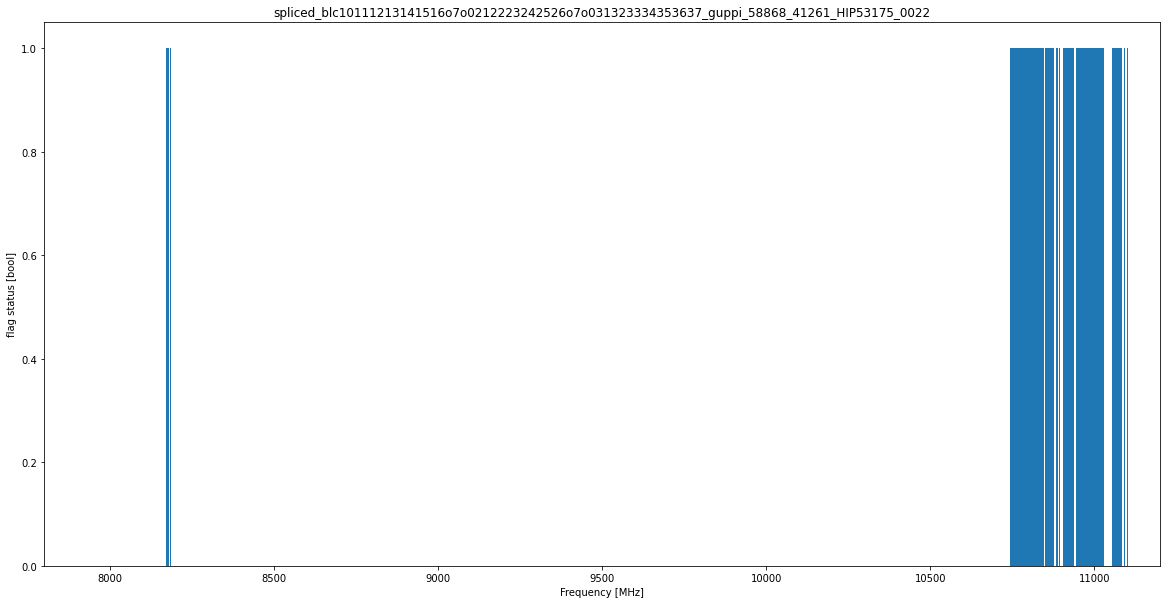

In [50]:
save_dir = "/home/danielb/plots/"

i = 0
plt.figure(figsize=(20,10))
plt.title(files[i])
plt.bar(freqs[i], 1, 1)
plt.xlim(7800, 11200)
plt.xlabel("Frequency [MHz]")
plt.ylabel("flag status [bool]");
# plt.savefig(save_dir + files[i] + ".pdf", bbox_inches='tight', transparent=False);

In [51]:
# missing_nodes = []
# missing_nodes.append(files[8])
# missing_nodes.append(files[4])
# missing_nodes.append(files[10])

In [52]:
def count_missing_node(flagged_freqs):
    jumps = np.where(np.diff(flagged_freqs, n=2) != 0)
    splits = jumps[0][::2] + 2
    spectral_intervals = np.split(flagged_freqs, splits)
    nodes_missing = 0
    for interval in spectral_intervals:
        length = len(interval)
        if length == 187 or length == 188 or length == 189:
            nodes_missing += 1
    return nodes_missing

In [53]:
files, freqs = flag_z(df, 7)

total = np.empty(len(freqs))
for i,thing in enumerate(freqs):
    node = count_missing_node(thing)
    total[i] = node

In [54]:
np.sum(total)

3.0

In [55]:
def files_missing_nodes(df):
    files, freqs = flag_z(df, 2)
    
    flagged_files = []
    for i in range(len(files)):
        if count_missing_node(freqs[i]) > 0:
            flagged_files.append(files[i])
    return flagged_files

In [56]:
flagged = files_missing_nodes(df)
flagged

['spliced_blc00010203040506o7o0111213141516o0212224252627_guppi_58806_44811_HIP68589_0132',
 'spliced_blc00010203040506o7o0111213141516o7o0212224252627_guppi_58806_25893_TIC160268701_0068',
 'spliced_blc00010203040506o7o0111213141516o0222324252627_guppi_58806_46297_HIP66308_0137',
 'spliced_blc00010203040506o7o0111213141516o7o0212224252627_guppi_58806_33792_TIC230088370_0097',
 'spliced_blc00010203040506o7o0111213141516o7o0212223242627_guppi_58810_20178_HIP98100_0055',
 'spliced_blc00010203040506o7o01112131416o7o021222324252627_guppi_58806_40722_HIP81940_0119',
 'spliced_blc00010203040506o7o0111213141516o7o0212224252627_guppi_58806_19083_TIC302518439_0046']

In [57]:
flagged[0].split("_")[1].replace("blc", "")

'00010203040506o7o0111213141516o0212224252627'

# Good Plots

In [120]:
x_files = glob.glob("/home/gcsfuse/blpc0/bl_tess/x_band/*0.h5")

In [130]:
x_files[4] not in a

True

In [128]:
x_files[1]

'/home/gcsfuse/blpc0/bl_tess/x_band/spliced_blc00010203040506o7o0111213141516o021222324252627_guppi_58806_22767_HIP50838_0058.gpuspec.0000.h5'

In [136]:
_ = "/home/gcsfuse/blpc0/bl_tess/x_band/"
x_files[index]

'/home/gcsfuse/blpc0/bl_tess/x_band/spliced_blc00010203040506o7o0111213141516o021222324252627_guppi_58806_43506_HIP76786_0128.gpuspec.0000.h5'

data loaded
extracting integration 0...


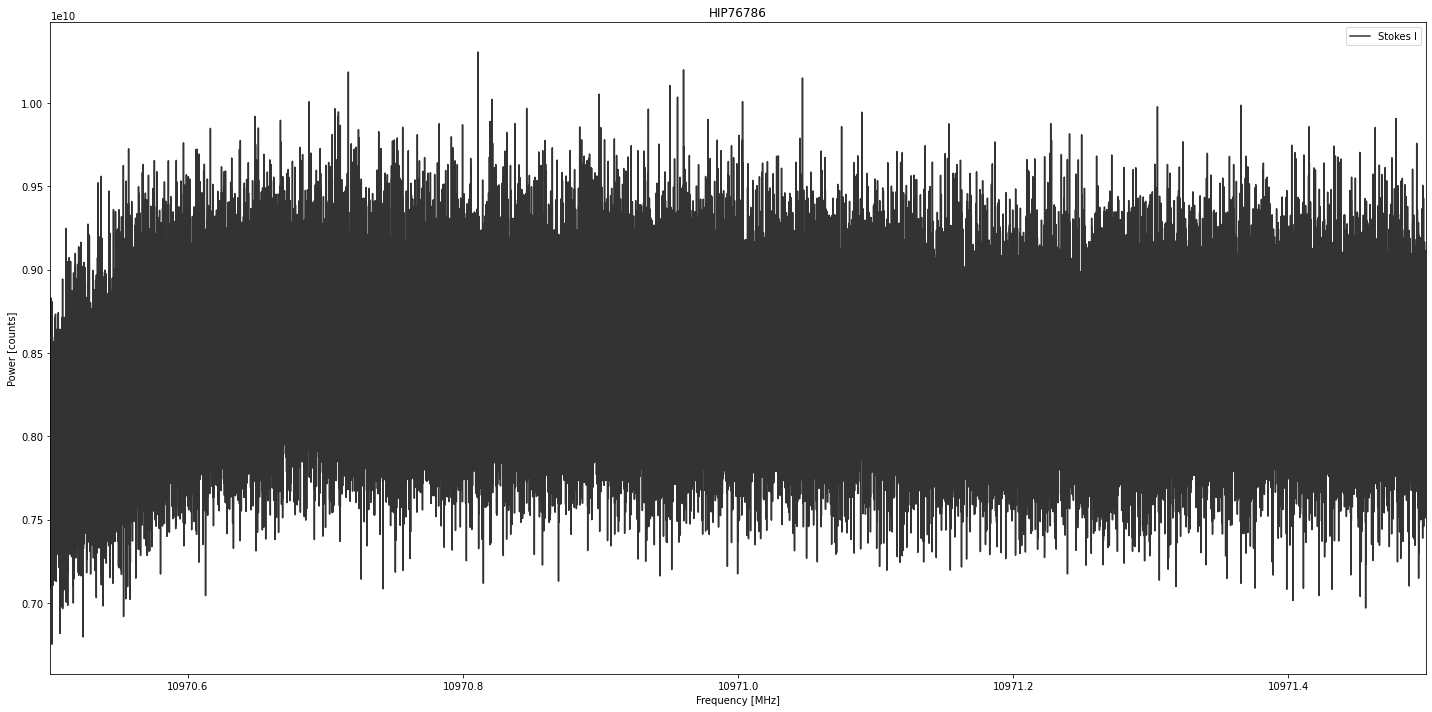

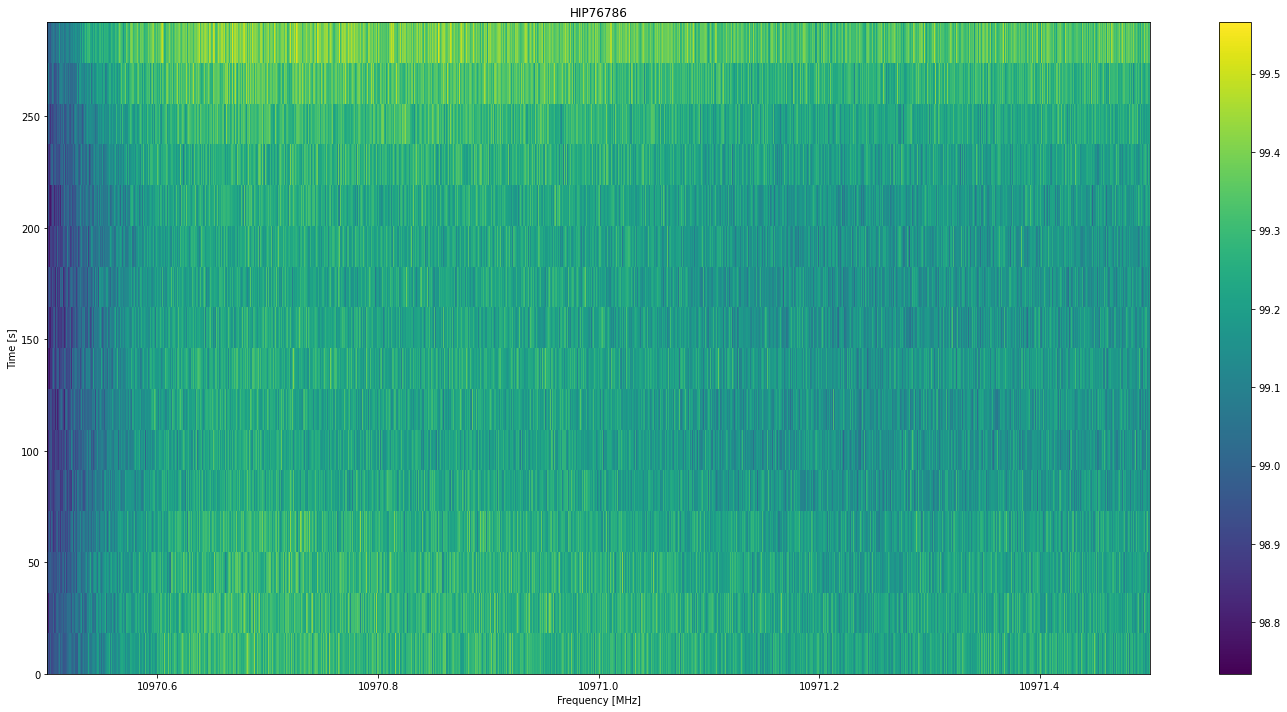

In [147]:
index = 4

f_start = 10970.5
f_stop  = 10971.5

save_dir = "/home/danielb/fall_2021/flagged_plots/good_plots/"
spectrum_path = save_dir + os.path.basename(x_files[index]) + "_%s_to_%s.pdf"%(f_start, f_stop)
waterfall_path = save_dir + os.path.basename(x_files[index]) + "_%s_to_%s_waterfall.pdf"%(f_start, f_stop)

# spectrum_and_waterfall(x_files[index], f_start, f_stop, spectrum_path, waterfall_path)

# Writeup plots


In [37]:
source_files = glob.glob("/datax/scratch/danielb/bl_tess/*.h5")
indices = np.arange(len(source_files))

In [40]:
for i in trange(len(source_files)):
    hf = bl.Waterfall(source_files[i], max_load=20)
    plt.figure(figsize=(8,8))
    hf.plot_waterfall()
    plt.tight_layout()
    plt.savefig("/home/danielb/fall_2021/all_band_plots/writeup_figs/plot_%s.png"%i, bbox_inches="tight", transparent=False)
    del hf
    gc.collect()
    plt.close("all")

  0%|                                                                                                                                                                | 0/2 [00:00<?, ?it/s]

blimpy.io.base_reader WARNING  Setting data limit = 20 GB > 1 GB, please handle with care!


 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 1/2 [03:24<03:24, 204.70s/it]

blimpy.io.base_reader WARNING  Setting data limit = 20 GB > 1 GB, please handle with care!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:37<00:00, 198.88s/it]


In [ ]:
spectrum_and_waterfall(h5_path, f_start, f_stop, 
                       spectrum_path=spectrum_path, 
                       waterfall_path=waterfall_path, 
                       max_load=6.5)